# Discrete transparent boundary conditions for the split Serre equations

* Modification of the serre.ipynb by Gaspard to add DTBC
* Definition and validation
* Objective : testing the TBC to the nonlinear Serre equations. We do not want to compare to NSWE as we are interested in the boundary conditions rather than in the numerical scheme (this study has already be done by Joao and Jose).


## Procedure
* Resolution of the advection part with a MUSCL scheme (no conditions needed here, we use ghost cells)
* Resolution of the dispersive part of the Serre equations
* Reference solution : solution computed in a larger domain
* BC for the dispersion : DTBC from the paper we wrote with Antoine (following Besse, Arnold, Kazakova, etc... works)



$\newcommand{\th}{\tilde{h}}$
$\newcommand{\tu}{\tilde{u}}$
$\newcommand{\lh}{\overline{h}}$
$\newcommand{\lu}{\overline{u}}$
$\newcommand{\Atwo}[2]{\left( \begin{array}{c} #1 \\ #2  \end{array} \right)}$

## Numerical resolution of the Serre equations

### The model

The Serre equations are a model to describe higly nonlinear waves propagating in shallow waters. Considering a horizontal bottom, these equations are written as

\begin{equation}
\label{eq:SerreFull}
h_t + (hu)_x = 0 \\
u_t + uu_x + gh_x - \frac{1}{3h}\left(h^3 \left( u_{xt} + uu_{xx} - (u_x)^2  \right) \right)_x = 0
\end{equation}

where $u = u(x,t)$, $h = h(x,t)$ and $g$ are, respectively, the depth-averaged horizontal velocity of the fluid, the water depth and the gravity acceleration.

### Splitting scheme

As done previously for the numerical resolution of the KdV and the BBM equations, the Serre equations will be numerically solved using a splitting method, in which the system of equations will be decomposed in two : the first one will contain the advection terms, and the second one, all the high-order derivative terms.

Therefore, the numerical resolution will consist in solve, in each time step $[t_n, t_{n+1}]$, the following problem :

\begin{equation}
\label{eq:SerreSplit1}
\begin{cases}
\th_t + \left(\th\tu\right)_x = 0 \\
\tu_t + \tu\tu_x + g\th_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\th,\tu)(x,t_n) = (h,u)(x,t_n)
\end{cases}
\end{equation}

\begin{equation}
\label{eq:SerreSplit2}
\begin{cases}
\lh_t   = 0 \\
\lu_t - \frac{1}{3\lh}\left(\lh^3 \left( \lu_{xt} + \lu\lu_{xx} - (\lu_x)^2  \right) \right)_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\lh,\lu)(x,t_n) = (\th,\tu)(x,t_{n+1})
\end{cases}
\end{equation}

\begin{equation}
\begin{cases}
(h,u)(x,t_{n+1}) = (\lh,\lu)(x,t_{n+1})
\end{cases}
\end{equation}


### Numerical resolution

We are not interested here in the numerical scheme. For more details, one should refer to the reports wrote by Joao and Jose. The important point to keep in mind is that we are working with a splitting scheme, and thus we need to describe the boundary conditions for the advection step and the dispersion step.

#### Advection

For the reference solution, as the domain is bigger this doesn't really mater. Periodic or Dirichlet is good.

For the computed solution (on the small domain), we pass to the 6 ghost cells necessary to the MUSCL scheme (advection solver) the value of the reference solution. Indeed, as this is an explicit scheme, there is no linear system to solve and TBC are not necessary for the DDM.

#### Dispersion

For the reference solution, as the domain is bigger this doesn't really mater. Periodic or Dirichlet is good.

For the computed solution (on the small domain), we impose here the DTBC we derived with Antoine. All the details are available in the paper we wrote with Antoine https://hal.inria.fr/hal-01797823 and in the report I wrote, wich is available in the same folder as this file.

## Resolution

#### Imports and creation of the serre_DTBC.py file

In [1]:
import notebook
notebook.nbextensions.check_nbextension('usability/codefolding', user=True)
notebook.nbextensions.check_nbextension('usability/codefolding/main.js', user=True)


False

In [2]:
import sys
sys.path.append('../')
sys.path.append('../nswe')

import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
%matplotlib notebook

nan = float('nan')

In [3]:
import generalFunctions as gF
import cnoidal
import nswe
import muscl2


In [4]:
%%writefile serre_DTBC.py
## Numerical resolution of the Serre equations

import sys
sys.path.append('../')
sys.path.append('../nswe')

import numpy as np
import matplotlib.pyplot as plt
import math
import generalFunctions as gF
import cnoidal
import nswe
import muscl2



Overwriting serre_DTBC.py


#### Auxiliary functions

In [5]:
%%writefile serre_DTBC.py -a

import csv

def csv_write(csvfile_path, data):
  """
  Write data into the path registered to csvfile_path.
  """

  with open(csvfile_path, 'w') as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for line in zip(*data):
      writer.writerow(line)

Appending to serre_DTBC.py


In [6]:
%%writefile serre_DTBC.py -a

def imposePeriodicity(v,ng) :
    """
    Impose periodicity to ng ghost cells
    """
    
    for i in range(ng) :
        v[0+i] = v[-2*ng+i]
        v[-1-i] = v[2*ng-(i+1)]
    return v

Appending to serre_DTBC.py


In [7]:
%%writefile serre_DTBC.py -a

def discretizeSpace(xmin,xmax,nx):
    """
    Create an array with nx points in [xmin,xmax)
    """
    
    dx = (xmax-xmin)/nx
    x = np.arange(xmin,xmax,dx)
    
    return x,dx

def discretizeSpaceFull(xmin,xmax,nx):
    """
    Create an array with nx points in [xmin,xmax]
    """
    
    x = np.linspace(xmin,xmax,nx)
    dx = np.diff(x)[0]
    
    return x,dx

Appending to serre_DTBC.py


#### Functions to impose boundary conditions of the FV scheme

In [8]:
%%writefile serre_DTBC.py -a

def openDomain0GC(h,hu,BC,dx,t,ref=[],idx=[]):
    """
    BC for an open domain with 0 ghost cells
    """
    
    return h,hu

Appending to serre_DTBC.py


In [9]:
%%writefile serre_DTBC.py -a

def periodicDomainTwoGC(h,hu,BC,dx,t):
    """
    Impose periodic BC for 2 ghost cells in the FV scheme
    """

    hb = 1.*h
    hub = 1.*hu
    
    hb[0] = h[-4]
    hub[0] = hu[-4]
    hb[-1] = h[3]
    hub[-1] = hu[3]
    
    hb[1] = h[-3]
    hub[1] = hu[-3]
    hb[-2] = h[2]
    hub[-2] = hu[2]
        
    return hb,hub

Appending to serre_DTBC.py


#### FV scheme

In [10]:
%%writefile serre_DTBC.py -a

import nswe_wbmuscl4 as wb4

def fluxes_periodic(h,hu,n,periodic,ng,u_refRK=[],h_refRK=[],idx=[]):
    """
    Creates the fluxes obtaines from a 4th order MUSCL reconstruction.
    Note that the MUSCL's stencil is such that we need 6 ghost cells, 3 on each side. 
    Hence we need to add these values. For a periodic scheme this is not too difficult, but for the 
    small domain, which is not periodic, we need to save the value of the reference solution 
    on the corresponding nodes. This is what is done here. with the arrays refRK_save.
    """
    
    if u_refRK == [] and h_refRK == []:
        u_refRK_save = np.zeros(6)
        h_refRK_save = np.zeros(6)
    else:
        u_refRK_save = []
        h_refRK_save = []
            
    ## first, we remove the ghost cells
    nx = h.shape[0]-2*ng
    ## then we add 3 cells on each side for the muscl scheme
    h0 = np.zeros(nx+6)
    u0 = np.zeros(nx+6)
    d0 = np.zeros(nx+6)
    h0[3:-3] = h[ng:len(h)-ng]
    u0[3:-3] = hu[ng:len(hu)-ng]
    u0 = np.where(h0>1e-10,u0/h0,0) #hu/h
    u = np.where(h>1e-10,hu/h,0)
    
    if idx != []:
        h0[:3] = h0[-6:-3]
        h0[-3:] = h0[3:6]
        u0[:3] = u0[-6:-3]
        u0[-3:] = u0[3:6]
        ## saving the reference
        idx1 = idx[0]
        idx2 = idx[1]
        u_refRK_save = np.append(u[idx1-3:idx1], u[idx2:idx2+3])
        h_refRK_save = np.append(h[idx1-3:idx1], h[idx2:idx2+3])
        
    elif u_refRK != [] and h_refRK != []:
        h0[:3]  = h_refRK[:3]
        h0[-3:] = h_refRK[-3:]
        u0[:3]  = u_refRK[:3]
        u0[-3:] = u_refRK[-3:]
        
    else:
        h0[:3]  = h0[3:6]
        h0[-3:] = h0[-6:-3]
        u0[:3]  = u0[3:6]
        u0[-3:] = u0[-6:-3]
    
    fp, fm, sc = wb4.fluxes_sources(d0,h0,u0)
    return fp, u_refRK_save, h_refRK_save

Appending to serre_DTBC.py


In [11]:
%%writefile serre_DTBC.py -a

def getRK4coef(uA,uB,f,dx,dt,nx,periodic,ng,u_refRK=[],h_refRK=[],idx=[]):
    """
    compute any of the RK4 coefficients (k_i)
    """
    
    F, u_refRK_save, h_refRK_save = f(uA,uB,nx,periodic,ng,u_refRK,h_refRK,idx)
    return -dt/dx*(F[0,1:] - F[0,:-1]), -dt/dx*(F[1,1:] - F[1,:-1]), u_refRK_save, h_refRK_save

def extend2GhostCells(v,ng):
    """
    complete the vector of RK4 coefficients with zeros in the ghost cells (to perform the sum u  + k_i)
    """
    
    return np.concatenate((np.zeros(ng),v,np.zeros(ng)))

def RK4(uA,uB,f,bcf,bcp,dx,dt,nx,t,periodic,ng,u_refRK=[],h_refRK=[],idx=[]):
    """
    RK4 for one time step
    """
    
    #### for the small domain, we need to impose the value of the bigdomain functions 
    #### on the 6 cells used for the MUSCL scheme
    #### ---> we are storing them in refRK_save
    u_refRK_save = np.zeros((4,6))
    h_refRK_save = np.zeros((4,6))
        
    uuA = np.copy(uA)
    uuB = np.copy(uB)
    if u_refRK == [] and h_refRK == []:
        k1A,k1B,u_refRK_save[0],h_refRK_save[0] = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,idx=idx)
    else:
        k1A,k1B,trash1,trash2 = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,u_refRK[0],h_refRK[0])
    k1A = extend2GhostCells(k1A,ng)
    k1B = extend2GhostCells(k1B,ng)

    uuA = uA+k1A/2.
    uuB = uB+k1B/2.
    if u_refRK == [] and h_refRK == []:
        k2A,k2B,u_refRK_save[1],h_refRK_save[1] = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,idx=idx)
    else:
        k2A,k2B,trash1,trash2 = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,u_refRK[1],h_refRK[1])
    k2A = extend2GhostCells(k2A,ng)
    k2B = extend2GhostCells(k2B,ng)

    uuA = uA+k2A/2.
    uuB = uB+k2B/2.
    if u_refRK == [] and h_refRK == []:
        k3A,k3B,u_refRK_save[2],h_refRK_save[2] = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,idx=idx)
    else:
        k3A,k3B,trash1,trash2 = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,u_refRK[2],h_refRK[2])
    k3A = extend2GhostCells(k3A,ng)
    k3B = extend2GhostCells(k3B,ng)

    uuA = uA+k3A
    uuB = uB+k3B
    if u_refRK == [] and h_refRK == []:
        k4A,k4B,u_refRK_save[3],h_refRK_save[3] = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,idx=idx)
    else:
        k4A,k4B,trash1,trash2 = getRK4coef(uuA,uuB,f,dx,dt,nx,periodic,ng,u_refRK[3],h_refRK[3])
    k4A = extend2GhostCells(k4A,ng)
    k4B = extend2GhostCells(k4B,ng)

    return uA + 1./6.*(k1A+2.*k2A+2.*k3A+k4A), uB + 1./6.*(k1B+2.*k2B+2.*k3B+k4B), u_refRK_save, h_refRK_save

Appending to serre_DTBC.py


#### Functions to impose boundary conditions on the FD scheme

In [12]:
%%writefile serre_DTBC.py -a

def periodicDomain2TwoGC(M,rhs,t,dx,BC):
    """
    Impose periodic BC for 2 ghost cells in the FD scheme
    """
    
    M[0,:] = 0.
    M[1,:] = 0.
    M[-1,:] = 0.
    M[-2,:] = 0.
    
    M[0,0] = 1.
    M[0,-4] = -1.
    
    M[1,1] = 1.
    M[1,-3] = -1.
    
    M[-1,-1] = 1.
    M[-1,3] = -1.
    
    M[-2,-2] = 1.
    M[-2,2] = -1.
    
    rhs[0] = 0.
    rhs[1] = 0.
    rhs[-1] = 0.
    rhs[-2] = 0.
    
    return M,rhs

Appending to serre_DTBC.py


In [13]:
%%writefile serre_DTBC.py -a

import convolution as cvl

def imposeBC_FV(M,rhs,BCs,h,u,hx,hu,dx,dt,nit,Y=[],uall=None):
    """
    Impose boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array containing one BC in each line, in the form
            [Position,Type,Value], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"Robin"/"DTBC"
                ::: Value (float) : value of the BC
        * h,hx,hu : informations from the last computation
        * dt, dx : time and space steps
        
    - Outputs :
        * M, modified for the BC
        * rhs, modified for the BC
    """
    
    gr = 9.81
    
    ## first loop to compute DTBC convolution parameters only once
    convol = False
    for i in range(BCs.shape[0]):
        [pos,typ,val] = BCs[i,:3]
        if typ == 'DTBC_Y':
            convol = True
            Ct = cvl.convolution_exact(nit, Y, uall)
            # uu = (1./hp1)*(h*u + dt*gr*h*hx) 
            uu = u + dt*gr*hx
            break
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        
        if typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*h[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
            
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
                
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 or pos == -2 :
                M[pos,pos] = dt*h[pos+1]*(alpha*dx - beta)
                M[pos,pos+1] = beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos+1]*(\
                                    alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                    beta*(u[pos+1] - u[pos] + dt*gr*(hx[pos+1]-hx[pos])) - dx*val)
            elif pos == 1 or pos == -1 :
                M[pos,pos] = dt*h[pos-1]*(alpha*dx + beta)
                M[pos,pos-1] = -beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos-1]*(\
                                            alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                            beta*(u[pos] - u[pos-1] + dt*gr*(hx[pos]-hx[pos-1])) - dx*val)
                            
        elif typ == "DTBC_Y":
            
            M[pos,:] = 0.
            
            if pos == 0:
                # Left TBC 1 ==> unknown = U[0]
                M[pos,0]   =  1.
                M[pos,1]   = -   Y[4,0]*h[0]/h[1]
                M[pos,2]   =     Y[6,0]*h[0]/h[2]
                val        = Ct[4,1] - Ct[6,2]
                rhs[pos]   = -(h[0]/dt)*( val - uu[0] + Y[4,0]*uu[1] - Y[6,0]*uu[2] )                
            elif pos == 1:
                # Left TBC 2 ==> unknown = U[1]
                M[pos,0]   =  1.
                M[pos,2]   = -   Y[5,0]*h[0]/h[2]
                M[pos,3]   =  2.*Y[8,0]*h[0]/h[3]
                M[pos,4]   = -   Y[7,0]*h[0]/h[4]
                val        = Ct[5,2] - 2*Ct[8,3] + Ct[7,4]
                rhs[pos]   = -(h[0]/dt)*( val - uu[0] + Y[5,0]*uu[2] - 2*Y[8,0]*uu[3] + Y[7,0]*uu[4] ) 
            elif pos == -1:
                ## Right TBC 1 ==> unknown = U[J]
                M[pos,-1]  =  1.
                M[pos,-2]  = -   Y[0,0]*h[-1]/h[-2]
                M[pos,-3]  =     Y[2,0]*h[-1]/h[-3]
                val        =  Ct[0,-2] - Ct[2,-3]
                rhs[pos]   = -(h[-1]/dt)*( val - uu[-1] + Y[0,0]*uu[-2] - Y[2,0]*uu[-3] )
            elif pos == -2:
                ## Right TBC 2 ==> unknown = U[J-1]
                M[pos,-1] =  1.
                M[pos,-2] = -2.*Y[0,0]*h[-1]/h[-2]
                M[pos,-3] =     Y[1,0]*h[-1]/h[-3]
                M[pos,-5] = -   Y[3,0]*h[-1]/h[-5]
                val       = 2*Ct[0,-2] - Ct[1,-3] + Ct[3,-5]
                rhs[pos]  = -(h[-1]/dt)*( val - uu[-1] + 2*Y[0,0]*uu[-2] - Y[1,0]*uu[-3] + Y[3,0]*uu[-5] )    
                
        else :
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/Robin/DTBC_Y")
        
    if convol:
        return M,rhs,Ct
    else:
        return M,rhs,[]

Appending to serre_DTBC.py


#### FD scheme

In [14]:
%%writefile serre_DTBC.py -a

def get1d(u,dx,periodic,order):
    """
    Compute first derivative
    """
    
    a = np.zeros_like(u)
    if order == 1:
        a[1:-1] = 1./(2.*dx)*(u[2:] - u[0:-2])
        a[0] = a[1]
        a[-1] = a[-2]
    elif order == 2:
        a[1:-1] = 1./(2.*dx)*(u[2:] - u[0:-2])
        a[0] = (-3*u[0] + 4.*u[1] - u[2])/(2.*dx)
        a[-1] = (3*u[-1] - 4.*u[-2] + u[-3])/(2.*dx)
    elif order == 4 :
        a[2:-2] = 1./(12.*dx)*(u[0:-4] - 8.* u[1:-3] + 8.*u[3:-1] - u[4:])
        #if (periodic) :
        #    a[0] = 1./(12.*dx)*(u[-3] - 8.* u[-2] + 8.*u[1] - u[2])
            ##### Todo Boundaries
            #a[1] = 1./(12.*dx)*(u[-2] - 8.* u[-1] + 8.*u[1] - u[2])
    return a

def get2d(u,dx,periodic,order=2):
    """
    Compute second derivative
    """
    
    a = np.zeros_like(u)
    a[1:-1] = 1./(dx*dx)*(u[2:] - 2.*u[1:-1] + u[0:-2])
    if order == 1:
        a[0] = a[1]
        a[-1] = a[-2]
    elif order == 2:
        if periodic :
            a[0] = 1./(dx*dx)*(u[1] - 2.*u[0] - u[-2])
            a[-1] = a[0]
        else :
            a[0] = 1./(dx*dx)*(2.*u[0] - 5.*u[1] + 4.*u[2] - u[3])
            a[-1] = 1./(dx*dx)*(2.*u[-1] - 5.*u[-2] + 4.*u[-3] - u[-4])
    elif order == 4 :
        a[2:-2] = 1./(12.*dx*dx)*(-u[0:-4] + 16.* u[1:-3] - 30*u[2:-2] + 16.*u[3:-1] - u[4:])
        #### TODO Boundaries
    return a

def get3d(u,dx,periodic,order=2):
    """
    Compute third derivative
    """
    
    a = np.zeros_like(u)
    a[2:-2] = 1./(2.*dx*dx)*(-u[0:-4] + 2.*u[1:-3] - 2.*u[3:-1] + u[4:])
    a[0] = 1./(dx*dx)*(-u[0] + 3.*u[1] - 3.*u[2] + u[3])
    a[1] = 1./(dx*dx)*(-u[1] + 3.*u[2] - 3.*u[3] + u[4])
    a[-1] = 1./(dx*dx)*(u[-1] - 3.*u[-2] + 3.*u[-3] - u[-4])
    a[-2] = 1./(dx*dx)*(u[-2] - 3.*u[-3] + 3.*u[-4] - u[-5])
    return a

Appending to serre_DTBC.py


In [15]:
%%writefile serre_DTBC.py -a

def EFDSolverFM4(h,u,dx,dt,t,order,BCfunction,BCparam=None,periodic=False,ng=2,Y=[],nit=0,uall=None,debug=False):
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche.
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction
        * periodic (boolean) : indicates if the function is periodic
        * ng : number of ghostcells
        * Y : convolution coefficients
        * nit : current iteration
        * uall : solution at previous iterations to compute convolution
        * debug : if True, increase verbosity
        
    - Returns
        * hu2/h (1D array) : solution (velocity)
    """
    
    gr = 9.81

    if periodic :
        for v in [u,h] :
            v = imposePeriodicity(v,ng)
    
    hu = h*u
    
    order = 2
    
    ux = get1d(u,dx,periodic,order=order)
    uxx = get2d(u,dx,periodic,order=order)
    uux = u*ux
    uuxdx = get1d(uux,dx,periodic,order=order)
    hx = get1d(h,dx,periodic,order=order)
    hxx = get2d(h,dx,periodic,order=order)
    h2x = get1d(h*h,dx,periodic,order=order)
    hhx = h*hx
    
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx
    rhs = gr*h*hx + h*Q  

    if periodic :
        for v in [ux,uux,uxx,uuxdx,h2x,hx,hhx] :
            v = imposePeriodicity(v,ng)   
    
    d0 = 1. + hx*hx/3. + h*hxx/3. + 5.*h*h/(6.*dx*dx)
    dp1 = -2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = +2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    dp2 = 1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dp2 = dp2[0:-2]
    dm2 = -1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dm2 = dm2[2:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2)

    np.set_printoptions(threshold=np.nan)
        
    if BCfunction != imposeBC_FV:
        M,rhs = BCfunction(M,rhs,t,dx,BCparam)
    else:
        M,rhs,Ct = BCfunction(M,rhs,BCparam,h,u,hx,hu,dx,dt,nit,Y,uall)
            
    z = np.linalg.solve(M,rhs)
    hu2 = hu + dt*(gr*h*hx-z)
    
    if Y != [] and debug:
        ## check the numerical validation of the DTBC
        u2 = hu2/h
        
        print " *  Left"
        print u2[0] - Y[4,0]*u2[1] - Ct[4,1] +   Y[6,0]*u2[2] +   Ct[6,2]
        print u2[0] - Y[5,0]*u2[2] - Ct[5,2] + 2*Y[8,0]*u2[3] + 2*Ct[8,3] - Y[7,0]*u2[4] - Ct[7,4] 
        
        print " *  Right"
        print u2[-1] -   Y[0,0]*u2[-2] -   Ct[0,-2] + Y[2,0]*u2[-3] + Ct[2,-3] 
        print u2[-1] - 2*Y[0,0]*u2[-2] - 2*Ct[0,-2] + Y[1,0]*u2[-3] + Ct[1,-3] - Y[3,0]*u2[-5] - Ct[3,-5]

    return hu2/h

Appending to serre_DTBC.py


#### Splitting scheme

In [16]:
%%writefile serre_DTBC.py -a

def splitSerre(x,h,u,t0,tmax,bcfunction1,bcfunction2,bcparam1,bcparam2,dx,dt,nx,
               splitSteps = 3, periodic=False,order=2,
               fvsolver=fluxes_periodic,fvTimesolver=RK4,fdsolver=EFDSolverFM4,
               ghostcells = 2,Y=[],debug=False,
               u_refRK=[],h_refRK=[], idx=[]):
    """
    Solve the Serre equations with a splitting scheme.
    
    - Parameters 
        * x : spatial domain of resolution
        * h,u : initial solution
        * t0, tmax : initial and final times
        * bcfunction, bcparam : boundary conditions functions and parameters for the advection (1) 
                                and the dispersion (2)
        * dx, dt : space and time steps
        * nx : number of nodes
        * splitSteps : how to perform the splitting, 2 --> adv + disp, 3 --> 0.5*adv + disp + 0.5*adv (Strang)
        * periodic : has to be True if the bcfunctions are periodic BC
        * order : order of the fdsolver
        * fvsolver : fluxes builder fo the advection
        * fvTimesolver : time step of the advection
        * fdsovler : FD solver
        * ghostcells : number of ghostcells
        * Y : convolution coefficient for the DTBC
        * debug : True to increase verbosity of the DTBC
        * u_refRK, h_refRK, idx : reference values for the 4 steps of the RK4 time step, along with idx of the node 
                                  to save in the case of the reference solution
        
    - Returns
        * hall,uall,tall : h, u arrays over time and the time array
        * u_refRK_save,h_refRK_save : if not empty, value of the reference solution on the corresponding nodes to 
                                      impose boundary conditions in the advection step of the small domain solution
    """
    
    t = t0
    it = 0
    grav = 9.8
    ng = ghostcells
    
    uall = u
    hall = h
    tall = np.ones(1)*t0

    print(r'CFL = %f' %(dt/(dx*dx*dx)))
    
    u_refRK_save = []
    h_refRK_save = []
    
    while t < tmax:
            
        if u_refRK == [] and h_refRK == []:
            u_refRK_it = []
            h_refRK_it = []
        else:
            u_refRK_it = u_refRK[it]
            h_refRK_it = h_refRK[it]
        
        hu = h*u
        h,hu = bcfunction1(h,hu,bcparam1,dx,t)
        
        if splitSteps == 3: ## Adv Disp Adv
            ## 0.5*adv
            h,hu,u_refRK_temp,h_refRK_temp = fvTimesolver(h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,periodic,
                                                          ng=ghostcells,u_refRK=u_refRK_it,h_refRK=h_refRK_it,idx=idx)
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)
            u = np.where(h[:]>1e-10, hu[:]/h[:], 0.)
            
            ## disp
            u = fdsolver(h,u,dx,dt,t,order,bcfunction2,bcparam2,
                         periodic=periodic,ng=ghostcells,Y=Y,nit=it+1,uall=uall,debug=debug)
            hu = h*u
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)
            
            ## 0.5*adv
            h,hu,u_refRK_temp,h_refRK_temp = fvTimesolver(h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,periodic,
                                                          ng=ghostcells,u_refRK=u_refRK_it,h_refRK=h_refRK_it,idx=idx)
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)
            u = np.where(h[:]>1e-10, hu[:]/h[:], 0.)
            
        elif splitSteps == 2 : ## Adv Disp
            ## adv
            h,hu,u_refRK_temp,h_refRK_temp = fvTimesolver(h,hu,fvsolver,bcfunction1,bcparam1,dx,dt,nx,t,periodic,
                                                          ng=ghostcells,u_refRK=u_refRK_it,h_refRK=h_refRK_it,idx=idx)
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)
            u = np.where(h[:]>1e-10, hu[:]/h[:], 0.)
            
            ## disp
            u = fdsolver(h,u,dx,dt,t,order,bcfunction2,bcparam2,
                         periodic=periodic,ng=ghostcells,Y=Y,nit=it+1,uall=uall,debug=debug)

        ## saving references in the big domain case
        if u_refRK == [] and h_refRK == []:
            u_refRK_save.append(u_refRK_temp)
            h_refRK_save.append(h_refRK_temp)
            
        ## next time        
        t = t+dt
        it += 1

        ## saving for plotting
        hall = np.column_stack((hall,h))
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
        ## plotting solutions
        if abs(t - 0.2) < 10**(-5):
            print " *  solution written in csv file"
            ## reference solution
            if idx != []:
                idx1 = idx[0]
                idx2 = idx[1]
                csv_write("data/u_ref_t{}.csv".format(t), [x[idx1:idx2], u[idx1:idx2]])
            ## computed solution
            else:
                csv_write("data/u_t{}.csv".format(t), [x, u])
            
                    
    return hall,uall,tall,u_refRK_save,h_refRK_save

Appending to serre_DTBC.py


#### Test case

In [17]:
## gaussian initial conditions

def gaussian(x, center, h0):
    h = h0 + 0.1*np.exp(-400*(x-center)*(x-center))
    u = np.zeros_like(h)
    return h,u

In [18]:
import serre_DTBC

init_cond = "gaussian" ## gaussian, solitary or cnoidal

## cnoidal and solitary initial conditions
if init_cond != "gaussian":
    a0 = 1.
    a1 = .1
    k = 0.
    g = 9.81
    t = 0.0
    tmax = 12.
    dt = 0.05

    lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

    L = 3.*lam
    xmin = -L
    xmax = L
    m = 2
    nx = 101
    nxref = 2*m*(nx-1)+nx 
    x,dx = serre_DTBC.discretizeSpaceFull(xmin,xmax,nx)
    xref,dxref = serre_DTBC.discretizeSpaceFull(-(2*m+1)*xmax,(2*m+1)*xmax,nxref)
    assert abs(dx-dxref) < 10**(-12)
        
    if init_cond == "cnoidal":
        h,u = cnoidal.analyticalSolution(x,t,k,a0,a1)
        href,uref = cnoidal.analyticalSolution(xref,t,k,a0,a1)
    else:
        h,u = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)
        href,uref = cnoidal.analyticalSolutionSolitary(xref,t,a0,a1)


## Gaussian initial condition
elif init_cond == "gaussian":
    g = 9.81
    t = 0.0
    tmax = .2
    dt = 0.001

    L = 3.
    xmin = -L
    xmax = L
    nx = 101
    m = 2
    nxref = 2*m*(nx-1)+nx
    x,dx = serre_DTBC.discretizeSpaceFull(xmin,xmax,nx)
    xref,dxref = serre_DTBC.discretizeSpaceFull(-(2*m+1)*xmax,(2*m+1)*xmax,nxref)
    assert abs(dx-dxref) < 10**(-12)

    h0 = 1
    
    h,u = gaussian(x, 0, h0)
    href,uref = gaussian(xref,0,h0)


In [19]:
## Convolution coefficients

import Zt_tools as Z
print h0
Nf = 10**3
ps = Z.Parameters(h0, dx, nx, xmin, xmax, dt, Nf)
# Y  = []
# Y  = Z.compute_Y3(ps)
# ub = 1.
# Y = Z.compute_Y2(ps, ub)
Y = Z.compute_Y(ps)
# Z.plot_Y(Y, Nf, log_scale = True, export = False, save = False)
# K = Z.compute_K(dx, 1)

1
*** Starting computations of Ys
*** Computation of Ys (in Fourier space) --> done

*** Applying iFFT on Ys
 *  max(Y1) = 0.941463621688
 *  max(Y2) = 0.941463621688
*** iFFT --> done



In [20]:
## Resolution

## big domain
print "\n*** Resolution on the big domain"
ng = 0   
    
## window for the reference solution to campare with the small domain solution
## so that the restriction of the reference solution to the small domain is uref[idx1:idx2]
idx1 = np.where(xref >= x[0])[0][0]
idx2 = np.where(xref >= x[-1])[0][0] + 1
idx = [idx1,idx2]


cond = "Dirichlet"
BCs = np.array([[0,cond,0.],
                [-1,cond,0.],
                [1,cond,0.],
                [-2,cond,0.]], dtype=object)

hall1,uall1,tall1,u_refRK1,h_refRK1 = serre_DTBC.splitSerre(xref,href,uref,0,tmax,
                                                           serre_DTBC.openDomain0GC,serre_DTBC.imposeBC_FV,
                                                           None,BCs,
                                                           dx,dt,nxref,
                                                           splitSteps=2,order=2,periodic=False,
                                                           fvsolver = serre_DTBC.fluxes_periodic, 
                                                           fdsolver = serre_DTBC.EFDSolverFM4,
                                                           ghostcells=ng,idx=idx)

## DTBC
print "\n*** Resolution on the small domain with DTBC"
cond_l = "DTBC_Y"
cond_r = "DTBC_Y"
BCs = np.array([[0,cond_l,0.],
                [-1,cond_r,0.],
                [1,cond_l,0.],
                [-2,cond_r,0.]], dtype=object)

## save initial condition for plotting
# serre_DTBC.csv_write("data/u_t{}.csv".format(0), [x, u])

hall2,uall2,tall2,trash1,trash2 = serre_DTBC.splitSerre(x,h,u,0,tmax,
                                                       serre_DTBC.openDomain0GC,serre_DTBC.imposeBC_FV,
                                                       None,BCs,
                                                       dx,dt,nx,
                                                       splitSteps=2,order=2,periodic=False,
                                                       fvsolver = serre_DTBC.fluxes_periodic, 
                                                       fdsolver = serre_DTBC.EFDSolverFM4,
                                                       ghostcells=0, Y=Y, debug = False,
                                                       u_refRK=u_refRK1,h_refRK=h_refRK1,idx=[])

umin = np.amin(uall2)
umax = np.amax(uall2)
hmin = np.amin(hall2)
hmax = np.amax(hall2)

print "\n*** Error"
print "u :", (np.linalg.norm(uall1[idx1:idx2]-uall2))
udiff = uall1[idx1:idx2]-uall2
udmin = np.amin(udiff)
udmax = np.amax(udiff)
print "h :", (np.linalg.norm(hall1[idx1:idx2]-hall2))


*** Resolution on the big domain
CFL = 4.629630


serre_DTBC.py:105: RuntimeWarning: invalid value encountered in divide
  u0 = np.where(h0>1e-10,u0/h0,0) #hu/h


 *  solution written in csv file

*** Resolution on the small domain with DTBC
CFL = 4.629630
 *  solution written in csv file

*** Error
u : 0.19096889041698004
h : 0.015032961635264068


#### Plotting

In [21]:
## plotting the error
lb = ["Difference"]
# save = "./u_error_TBC_Serre.mp4"
save = None
ng = 2
# gF.plotAnimationNSolutions(1,x,np.array([udiff]),tall1,xmin,xmax,udmin,udmax,lb,ylabel=r'$u$',location=(0.05,0.85),savePath=save)

*** Plotting animation ...



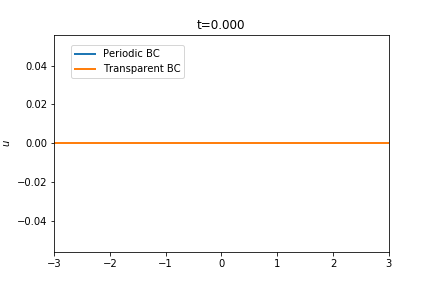
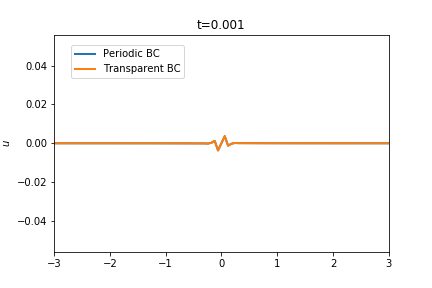
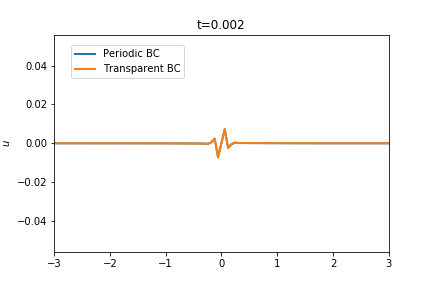
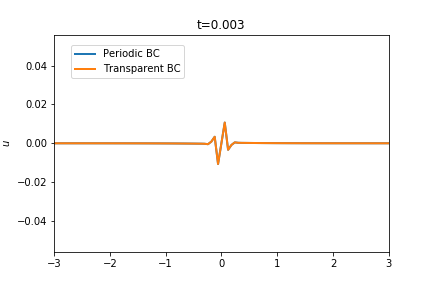
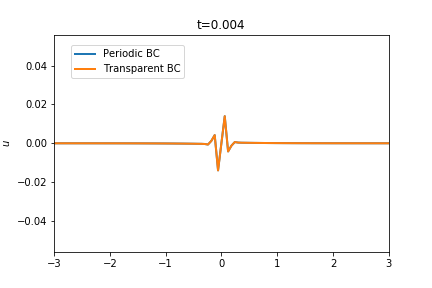
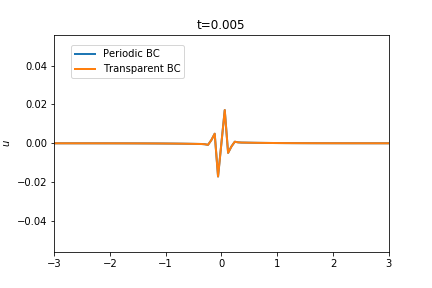
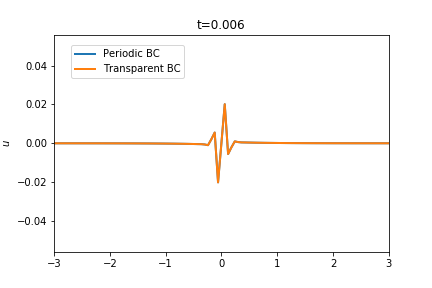
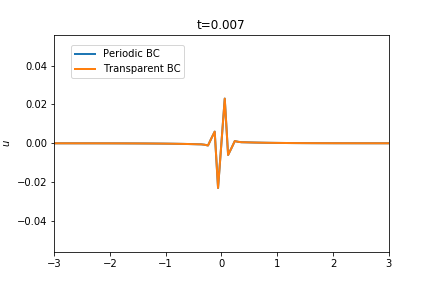
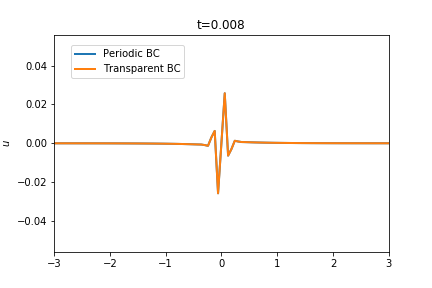
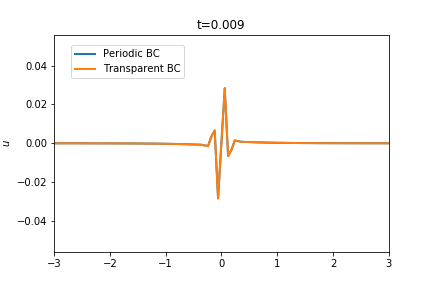
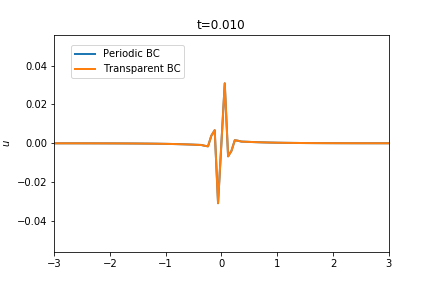
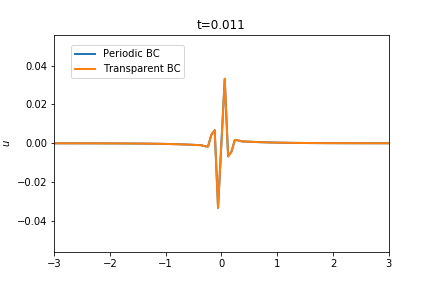
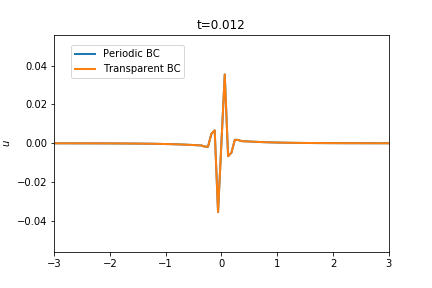
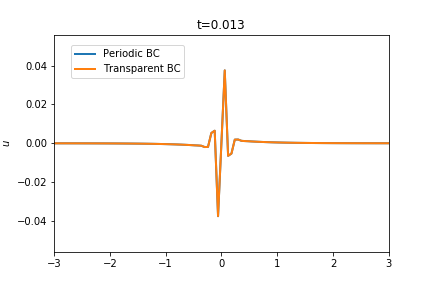
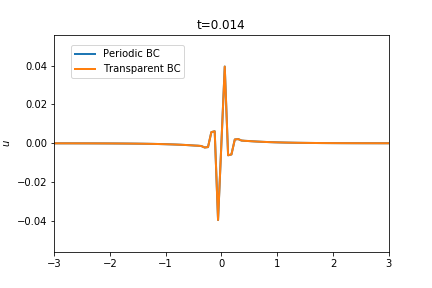
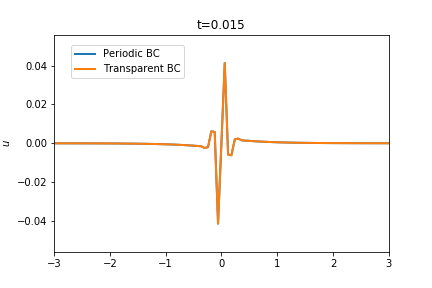
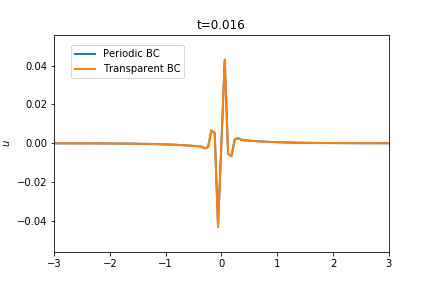
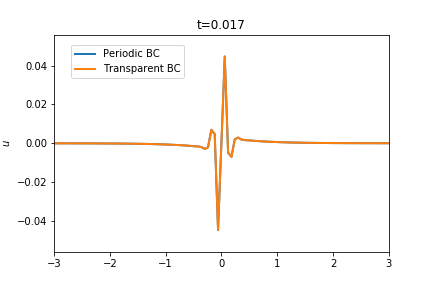
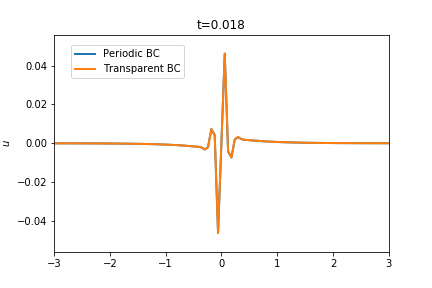
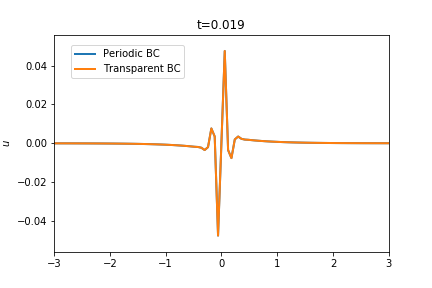
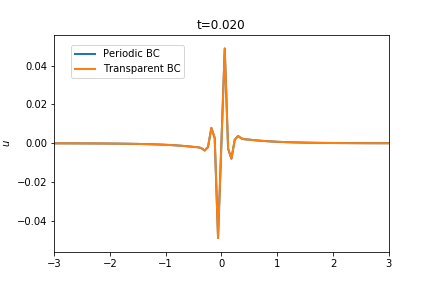
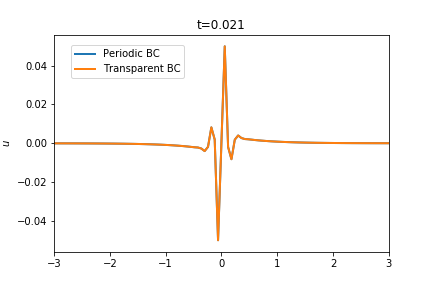
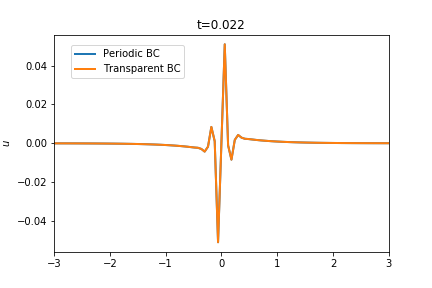
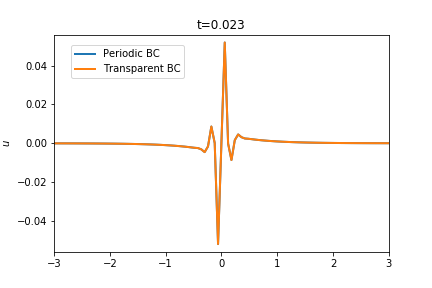
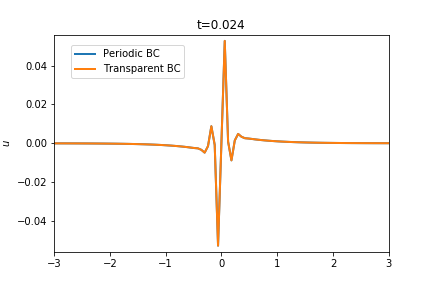
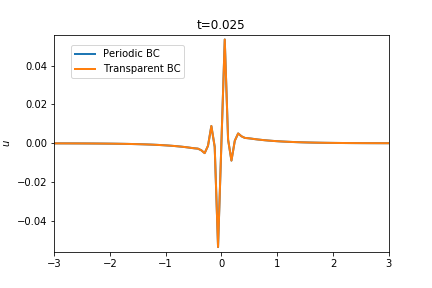
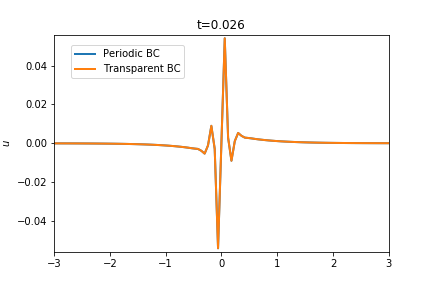
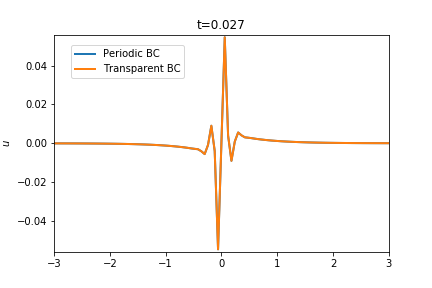
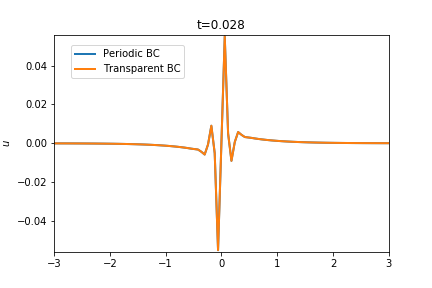
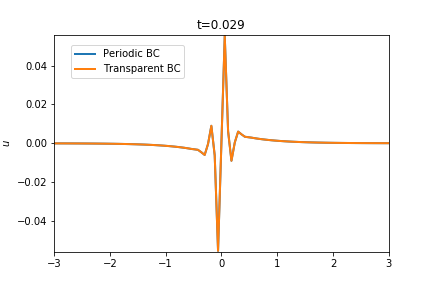
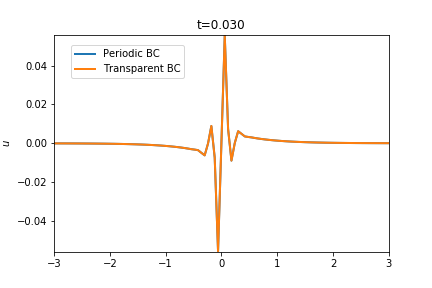
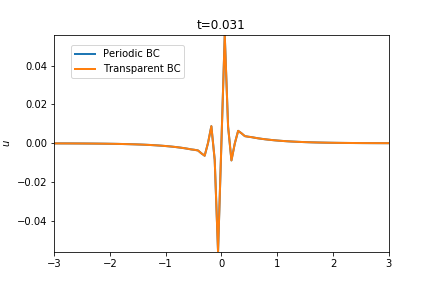
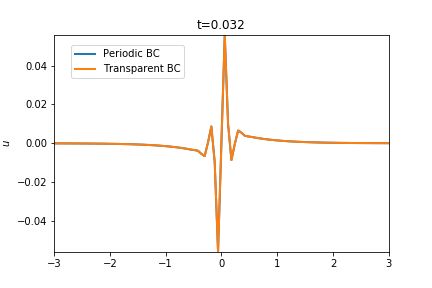
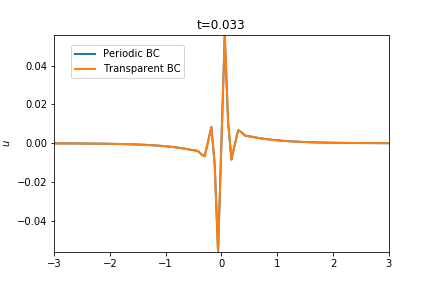
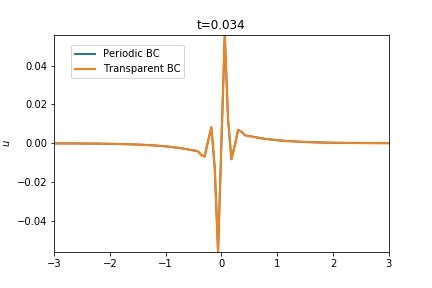
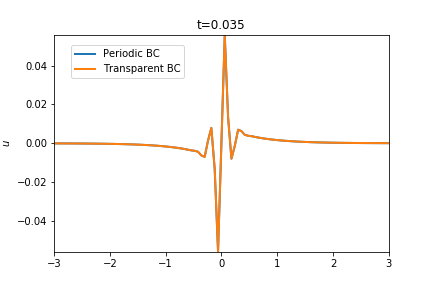
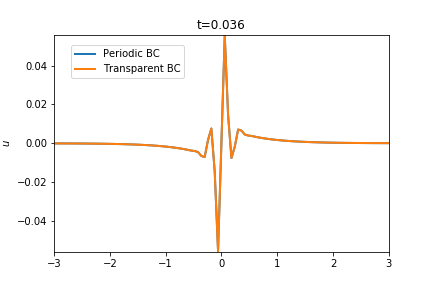
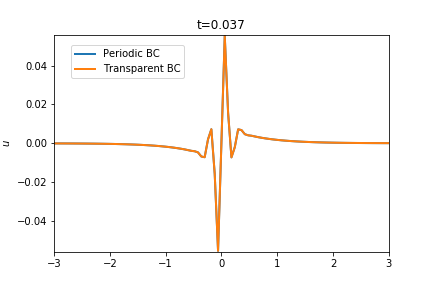
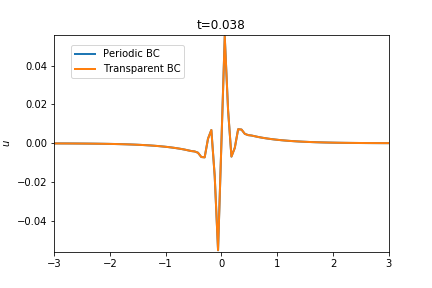
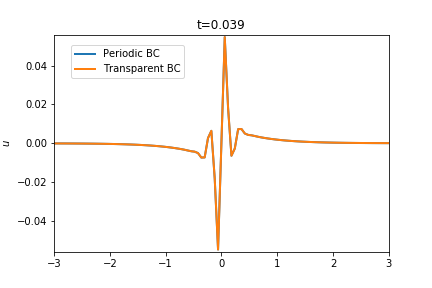
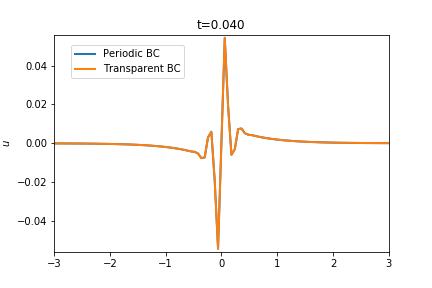
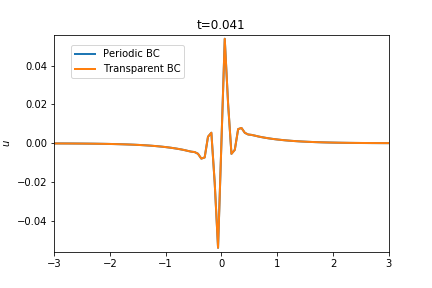
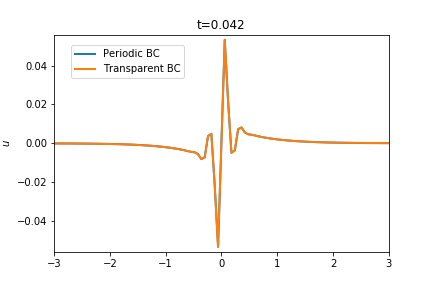
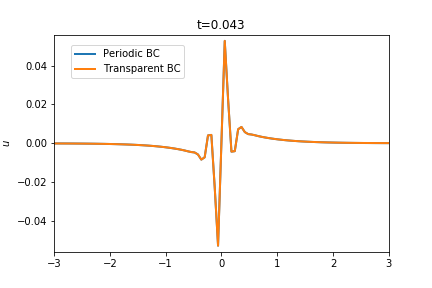
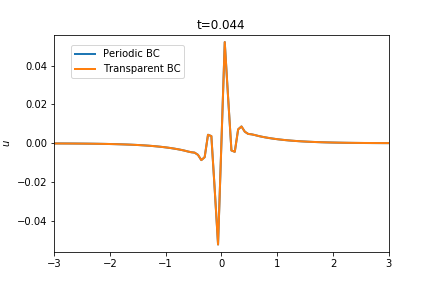
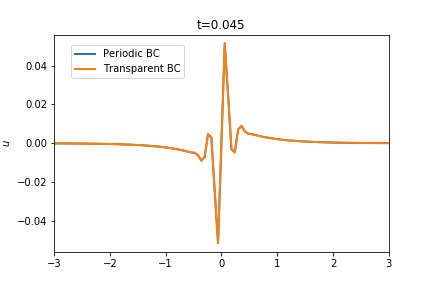
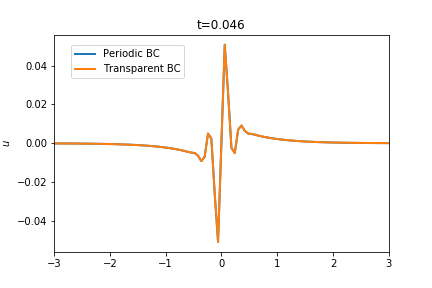
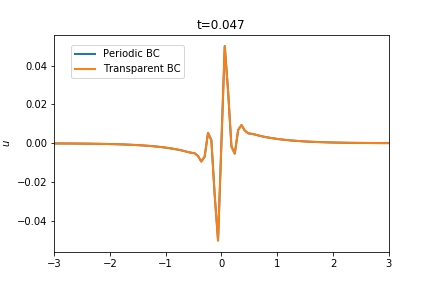
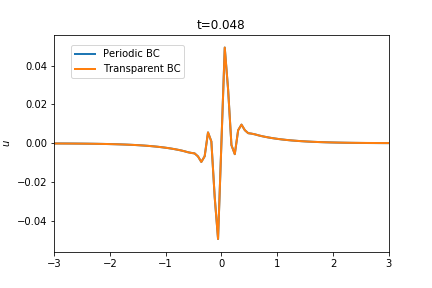
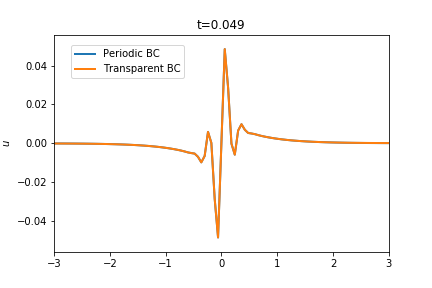
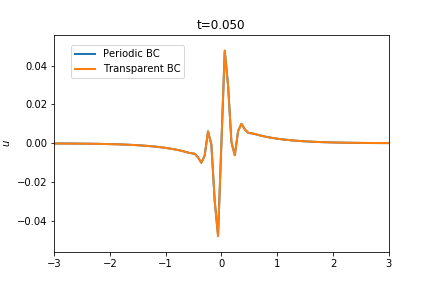
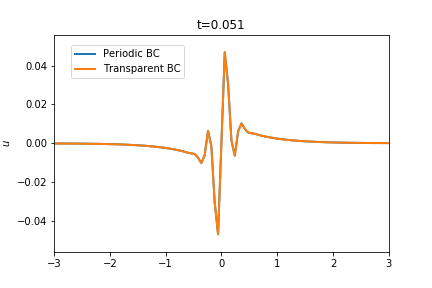
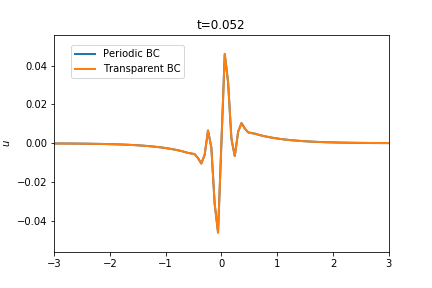
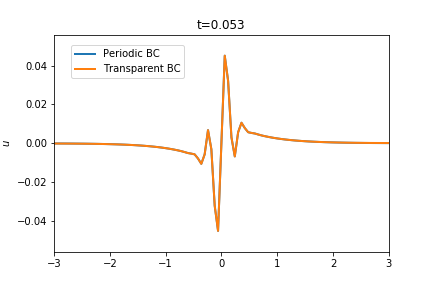
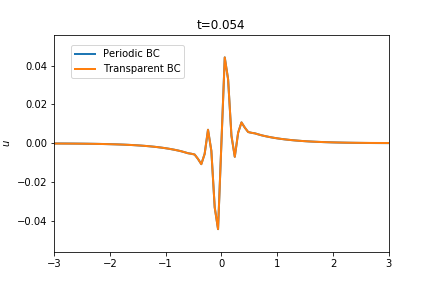
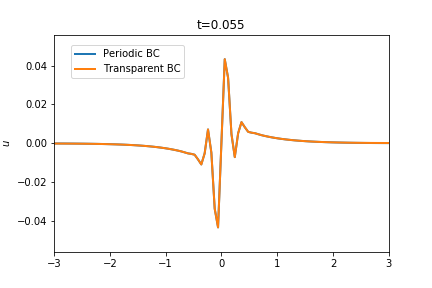
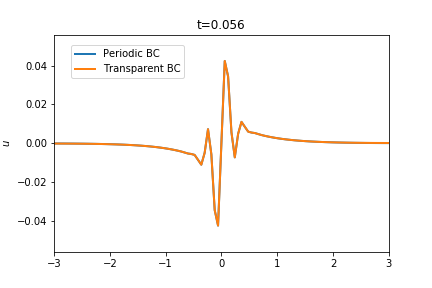
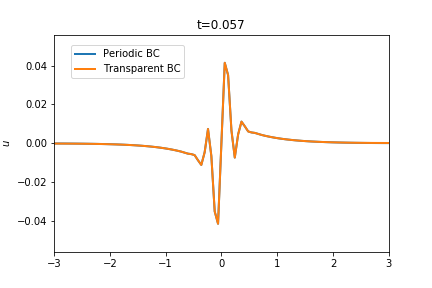
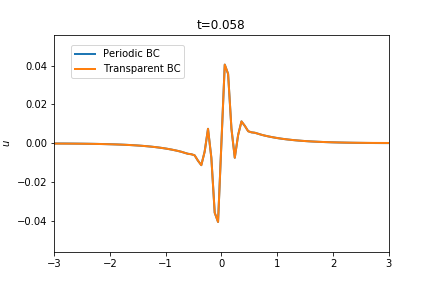
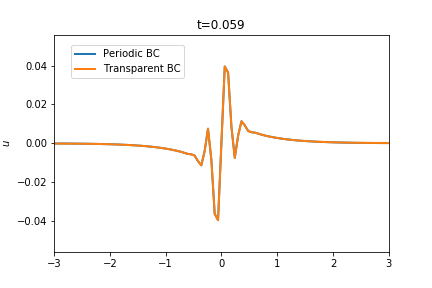
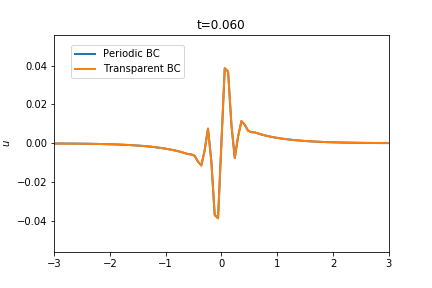
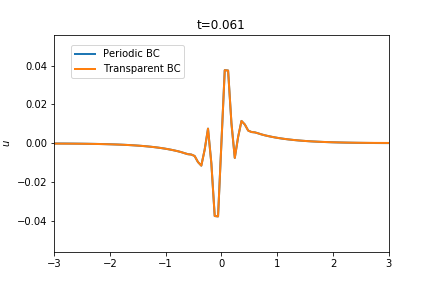
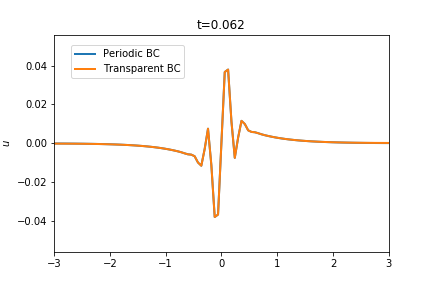
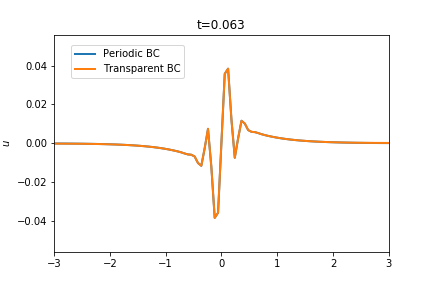
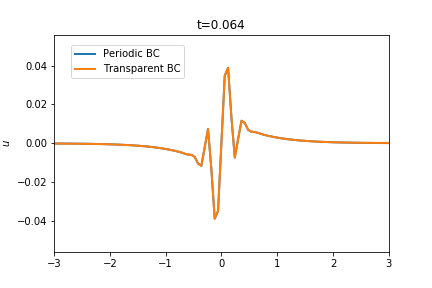
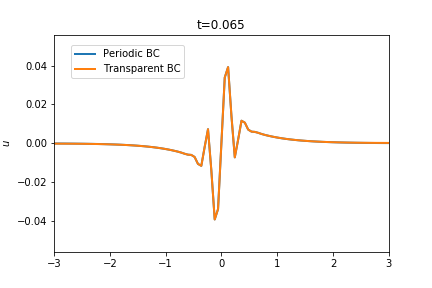
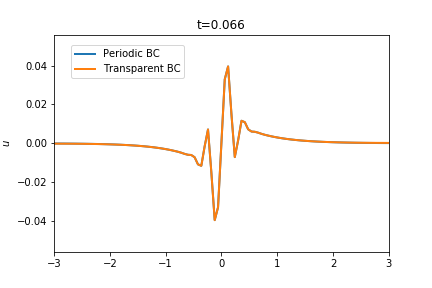
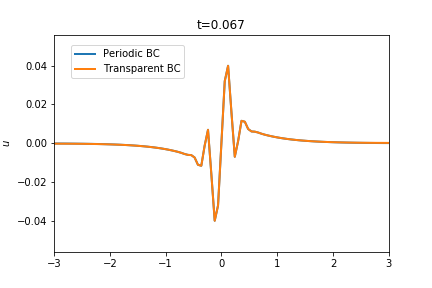
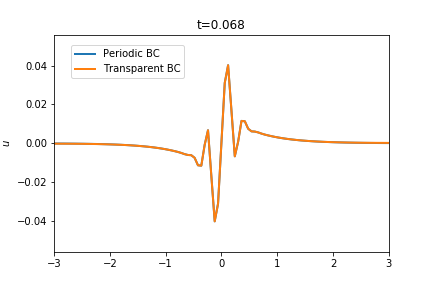
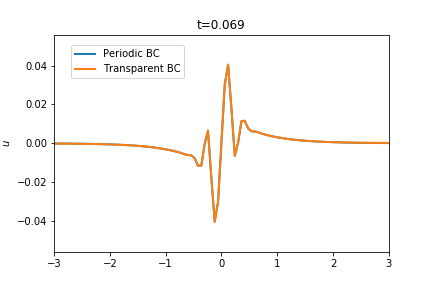
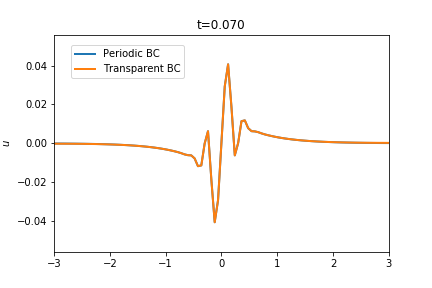
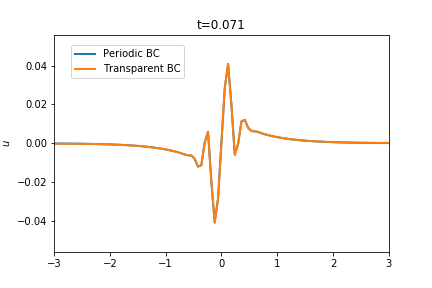
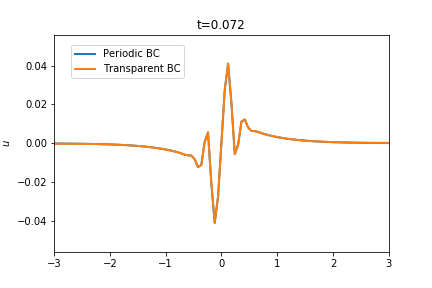
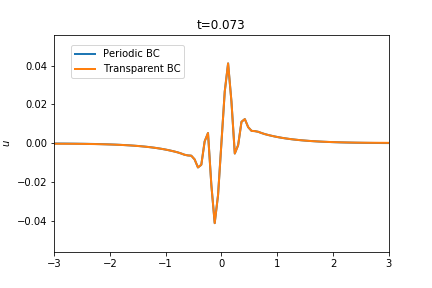
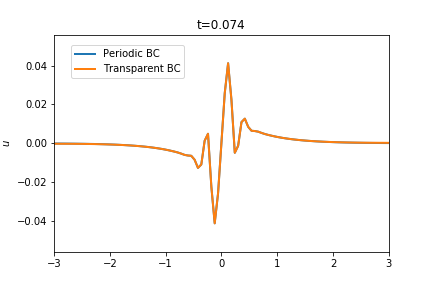
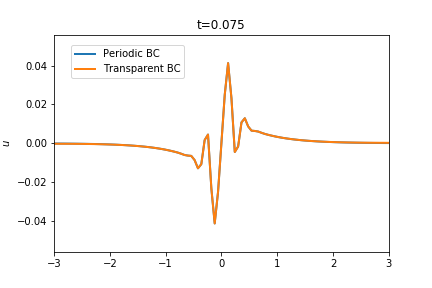
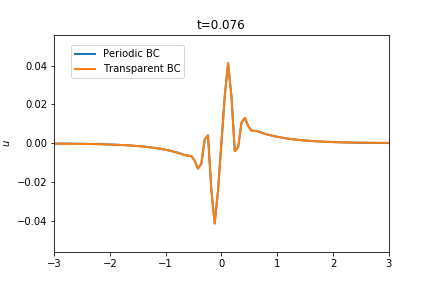
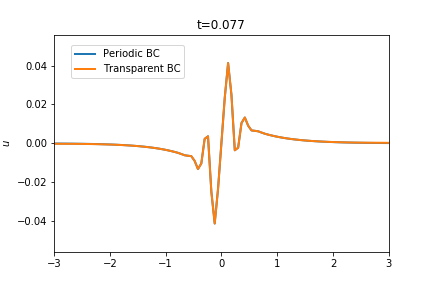
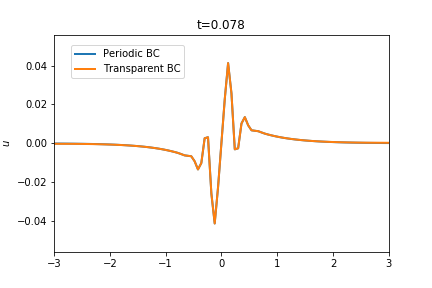
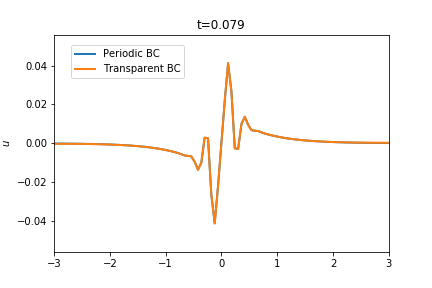
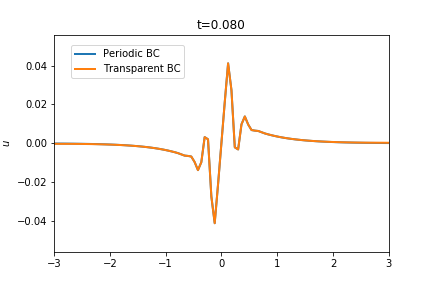
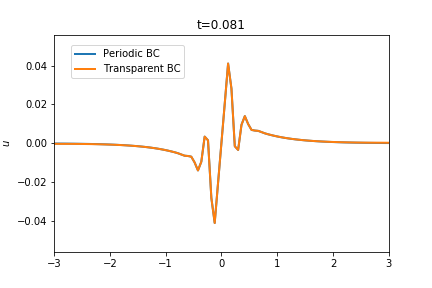
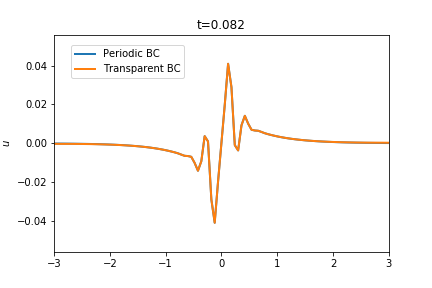
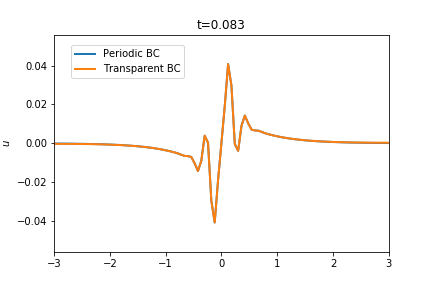
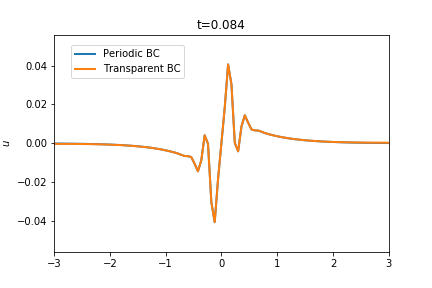
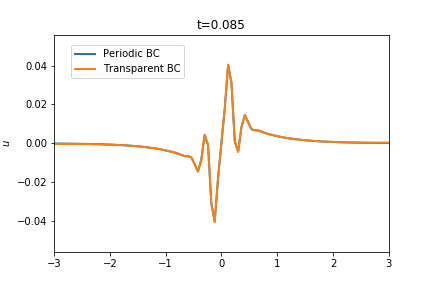
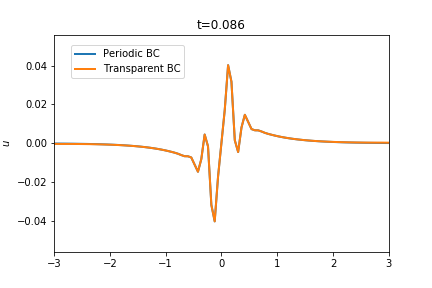
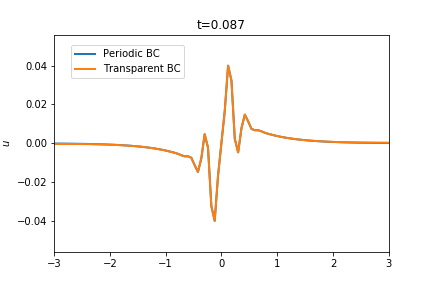
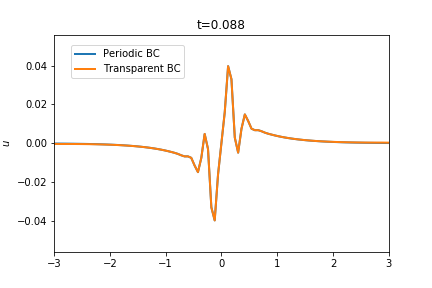
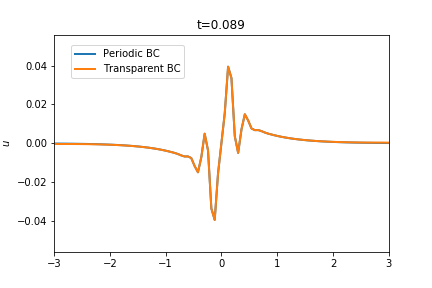
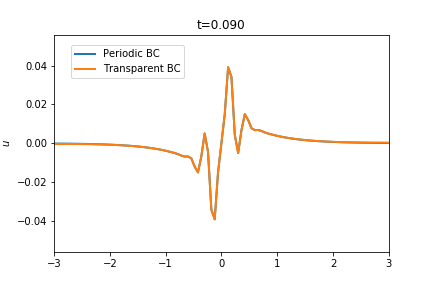
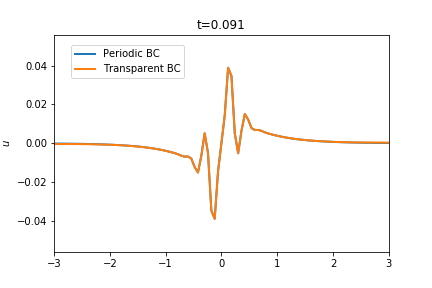
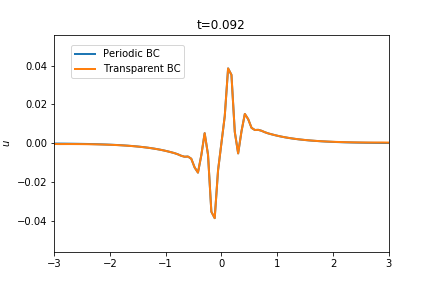
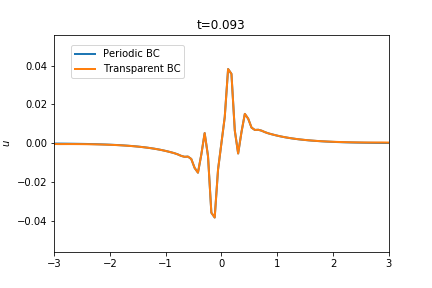
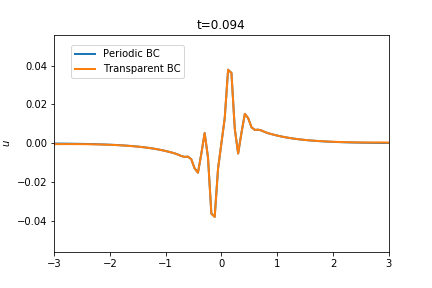
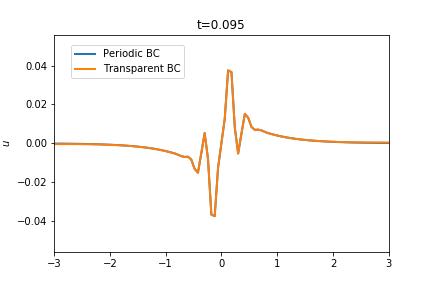
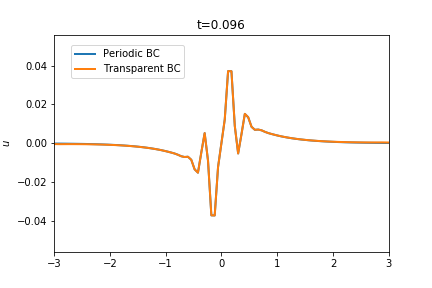
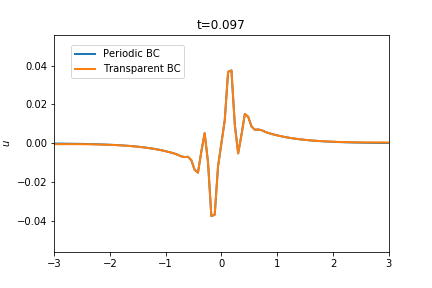
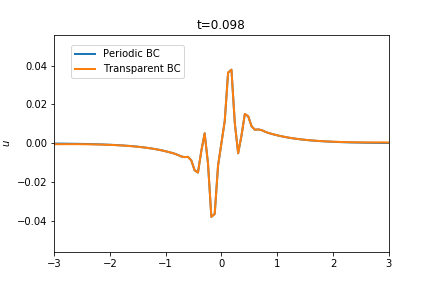
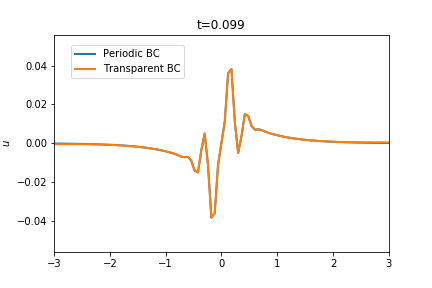
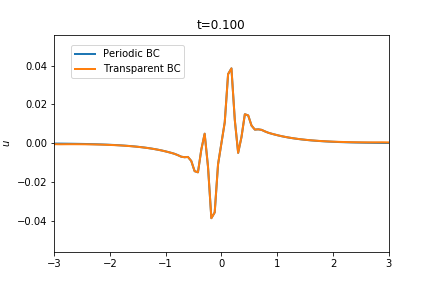
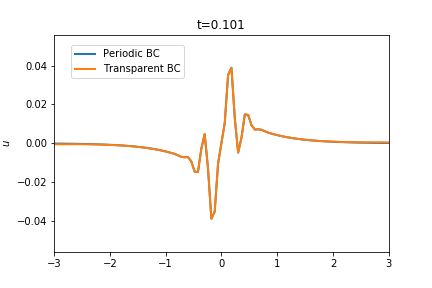
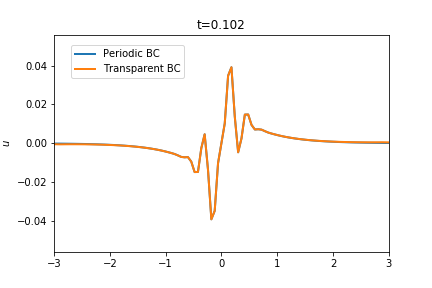
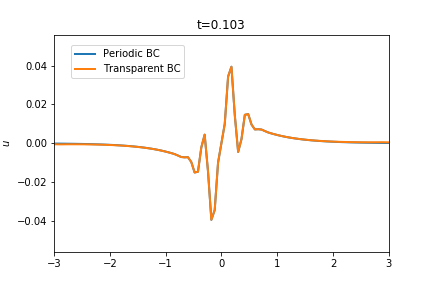
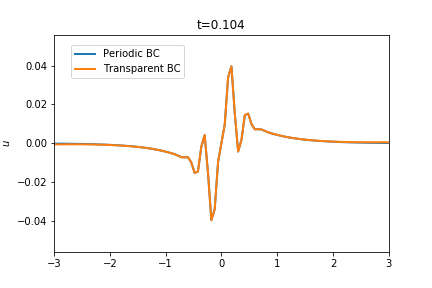
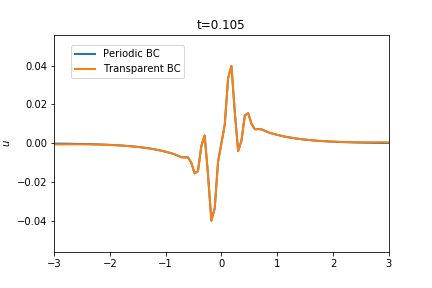
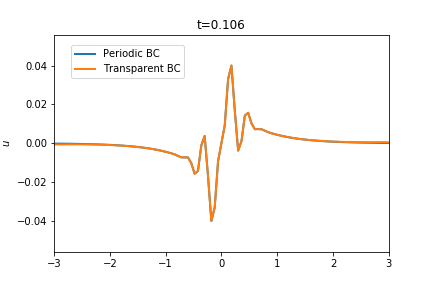
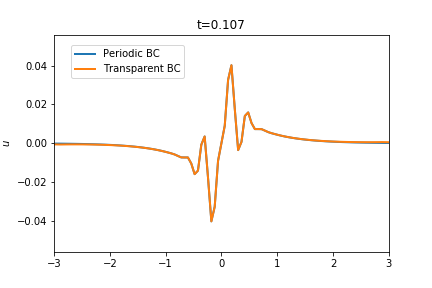
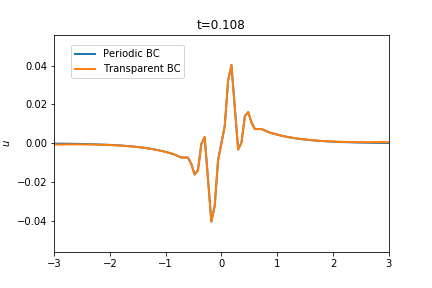
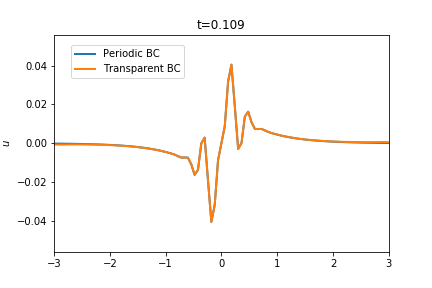
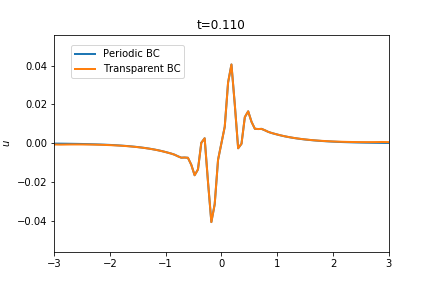
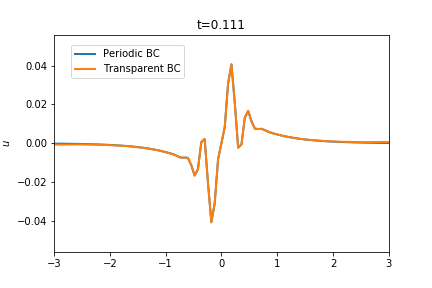
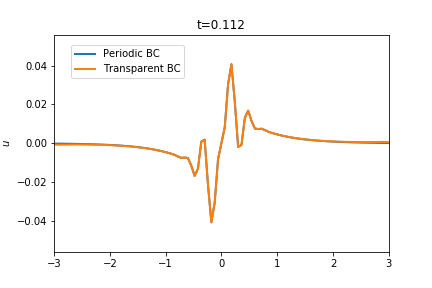
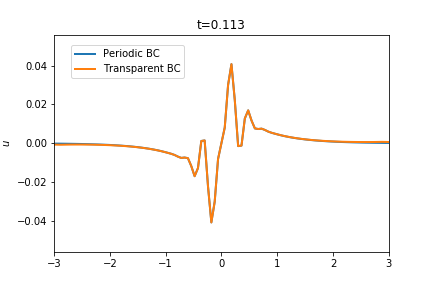
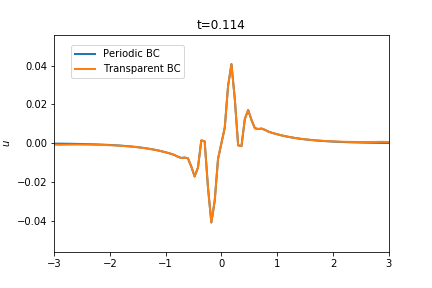
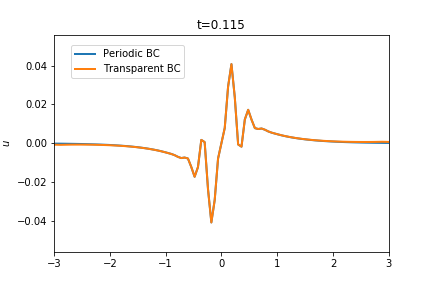
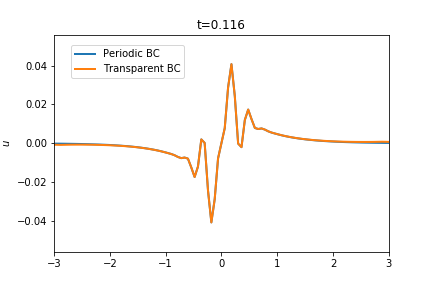
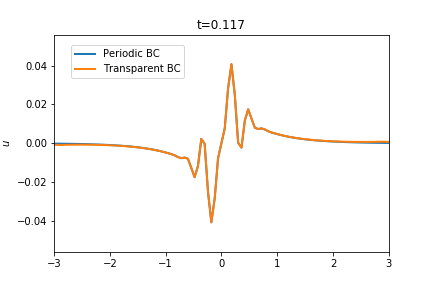
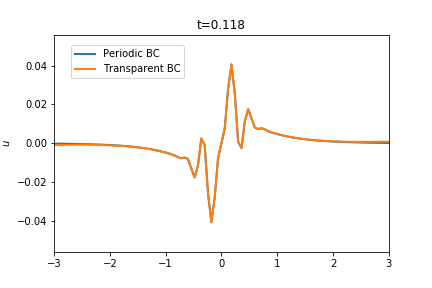
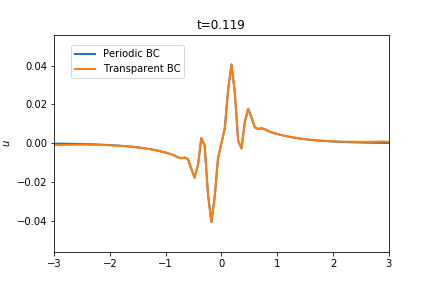
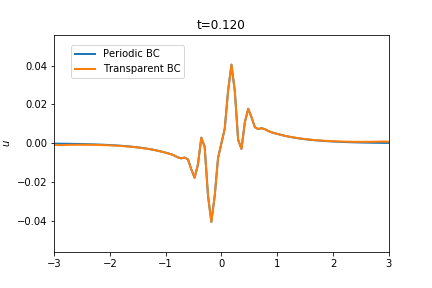
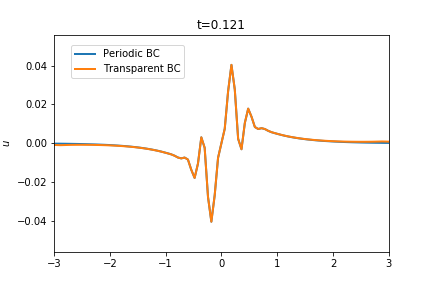
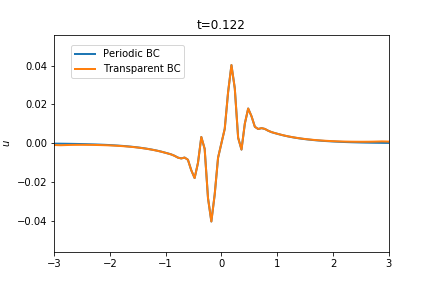
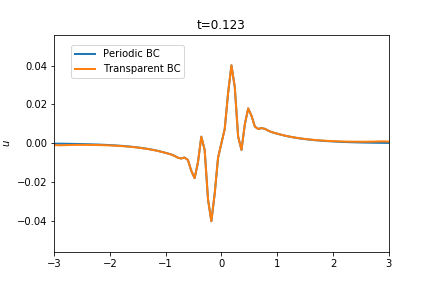
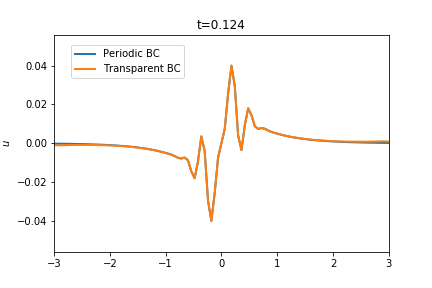
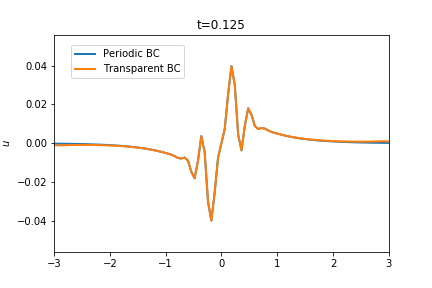
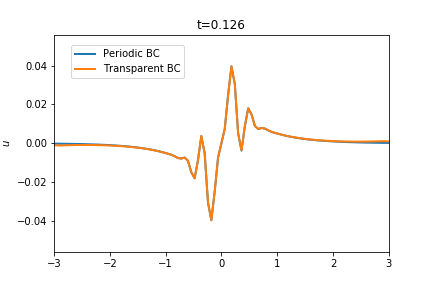
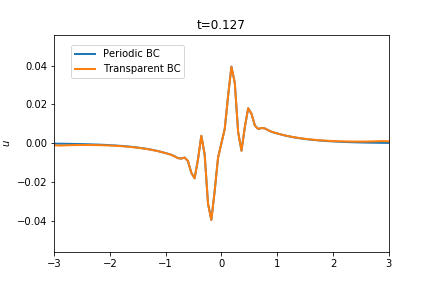
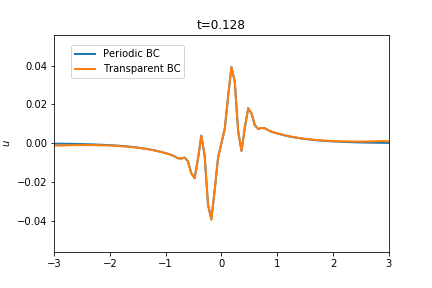
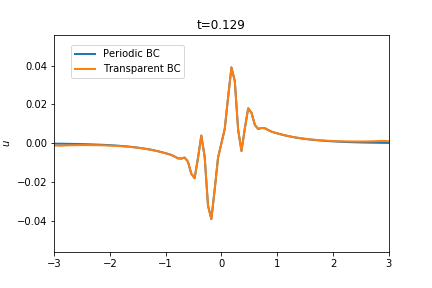
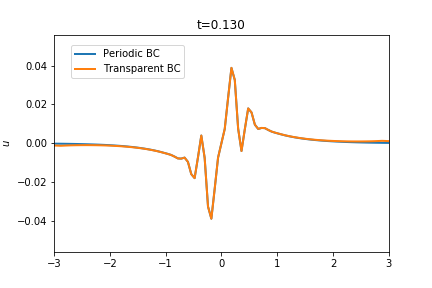
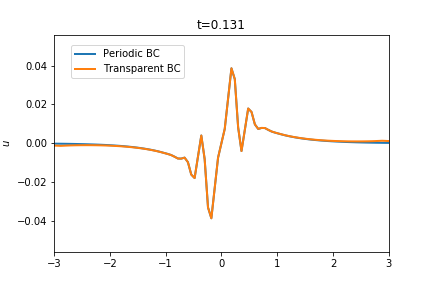
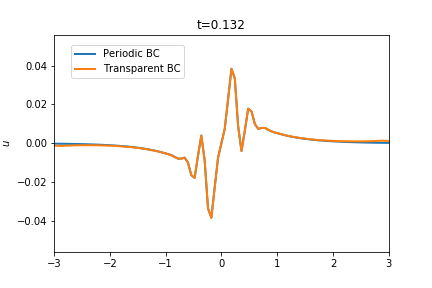
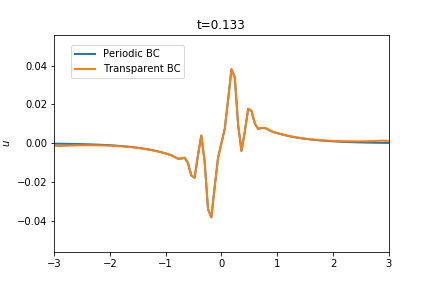
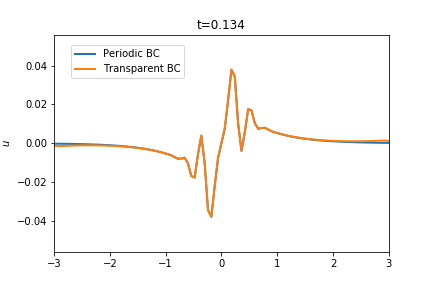
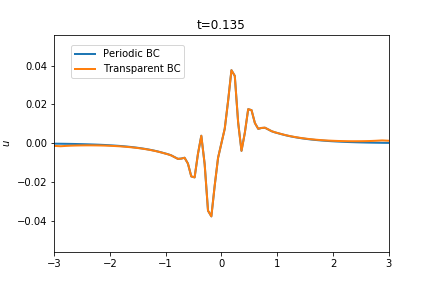
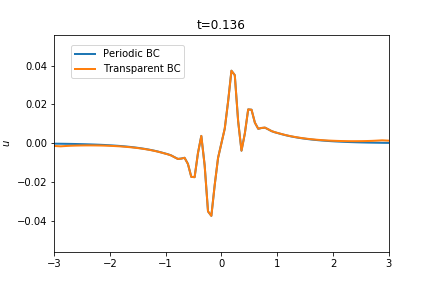
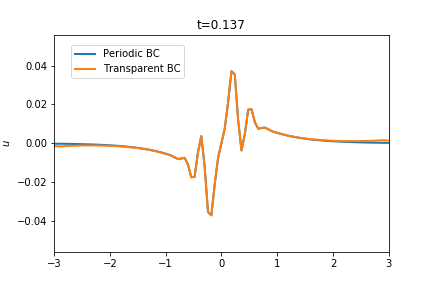
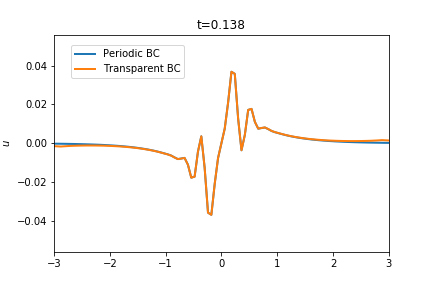
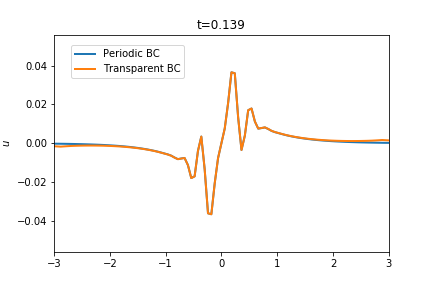
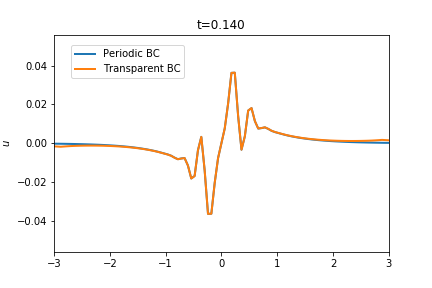
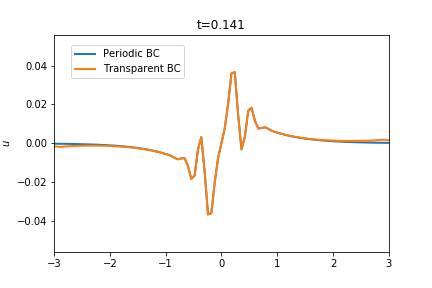
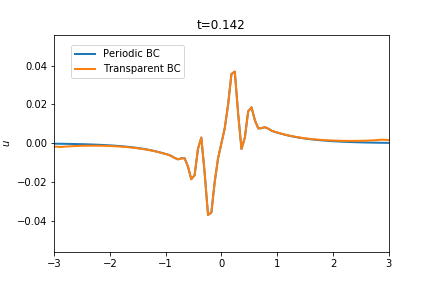
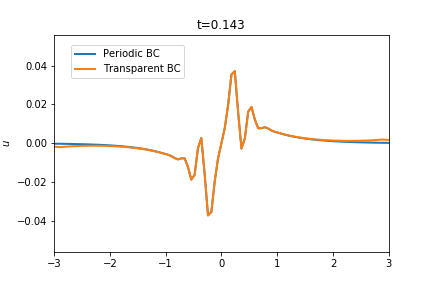
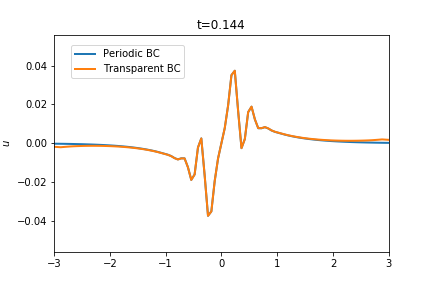
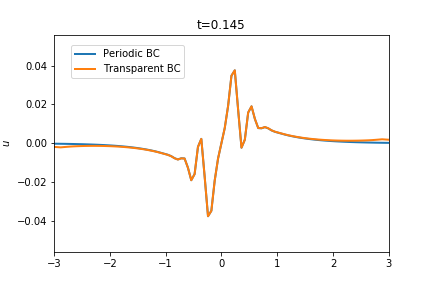
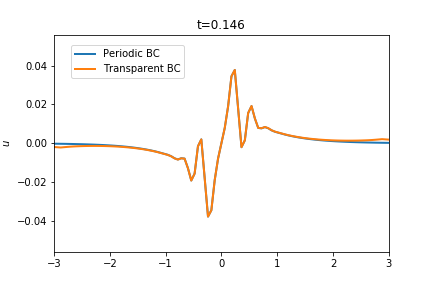
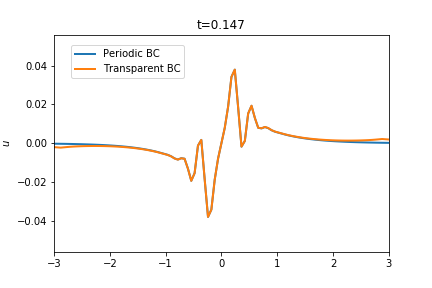
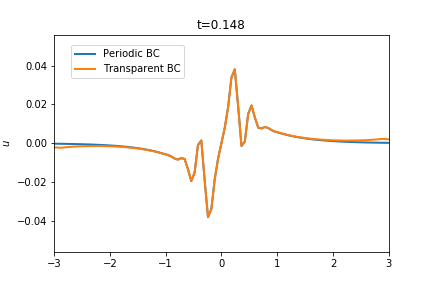
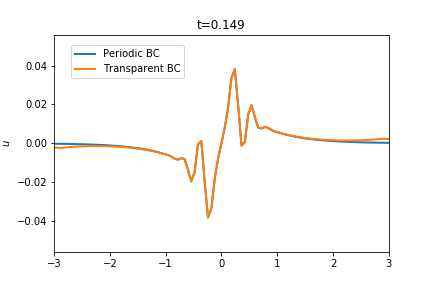
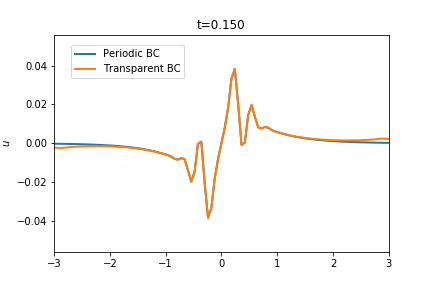
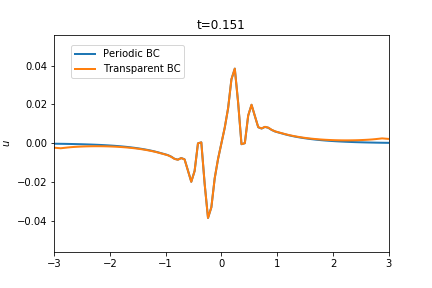
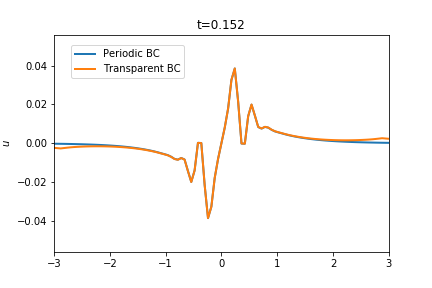
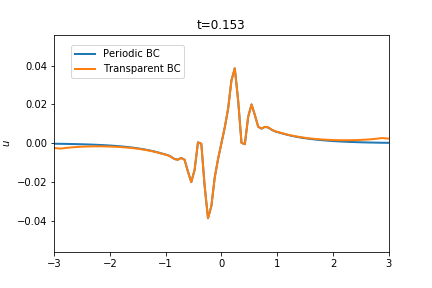
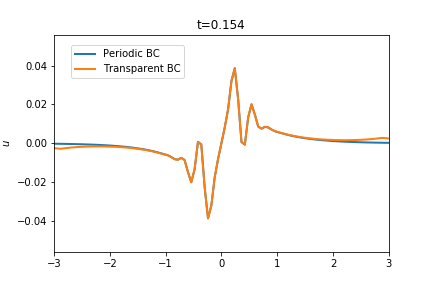
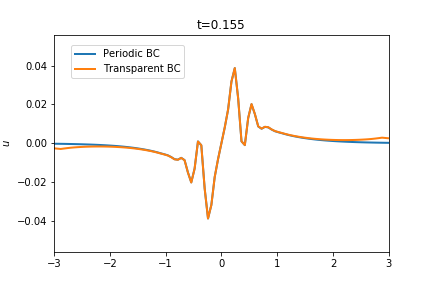
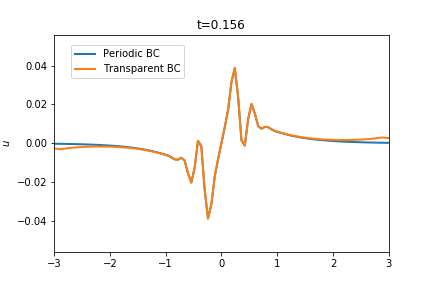
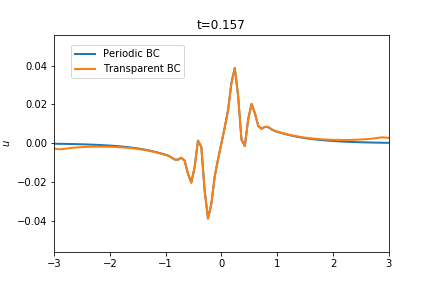
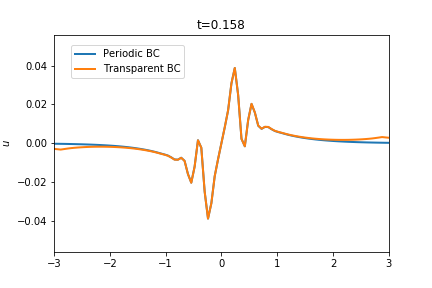
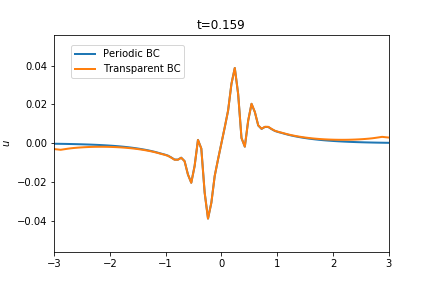
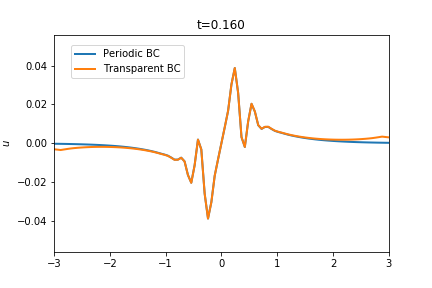
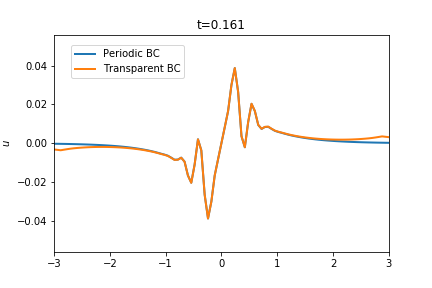
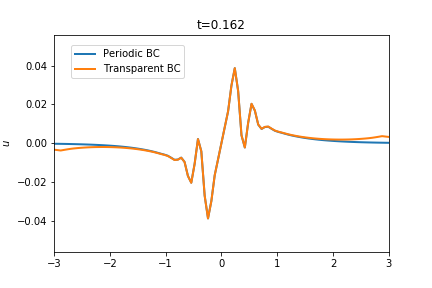
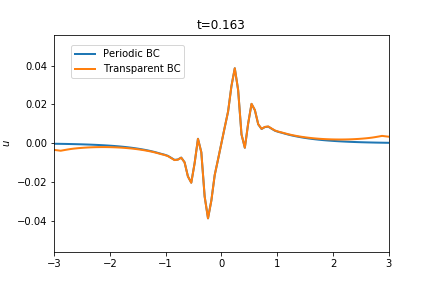
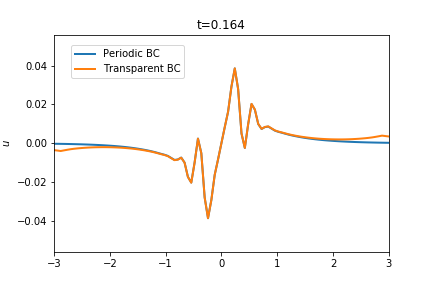
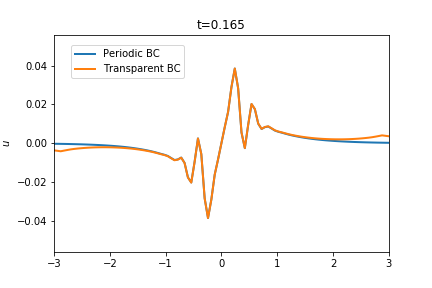
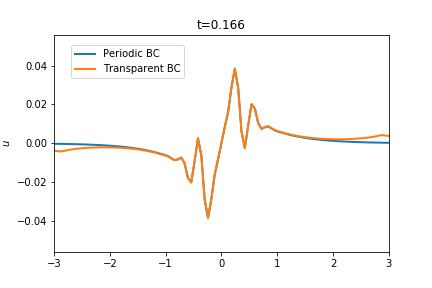
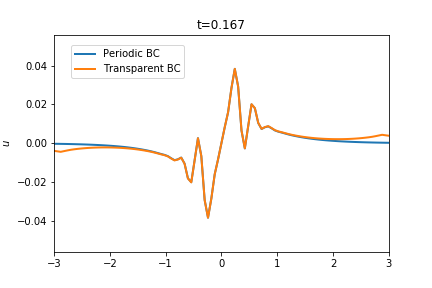
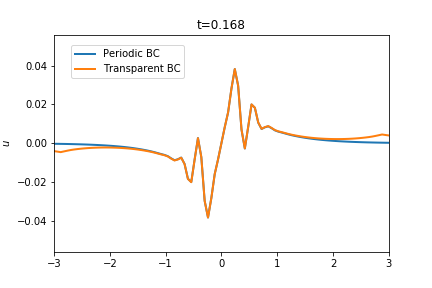
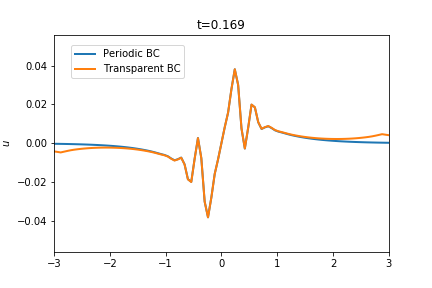
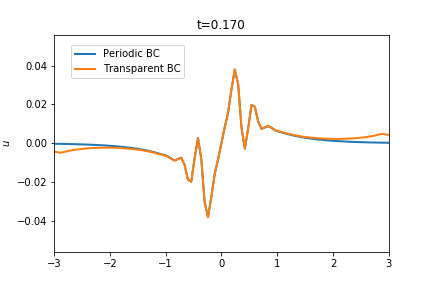
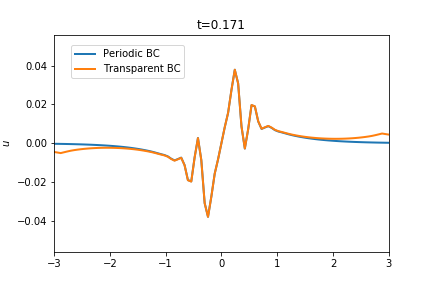
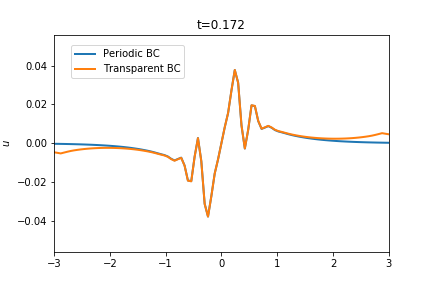
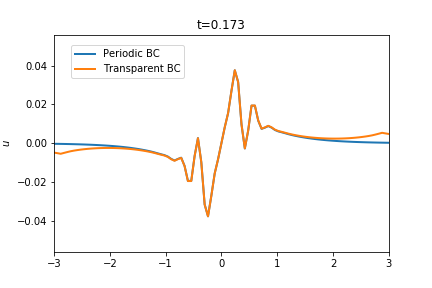
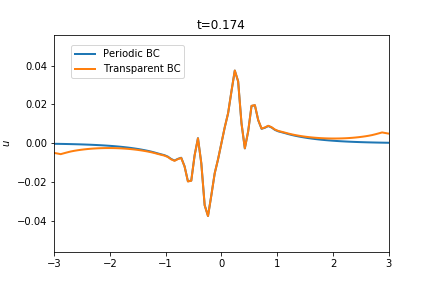
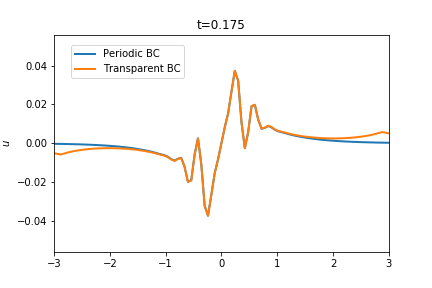
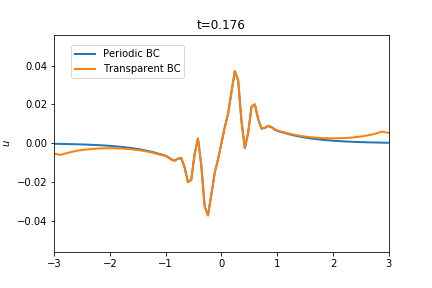
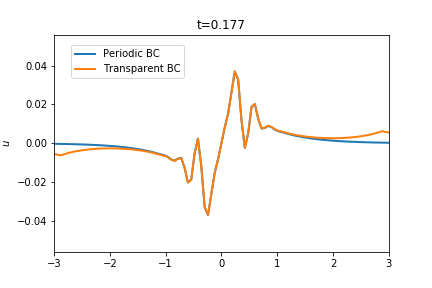
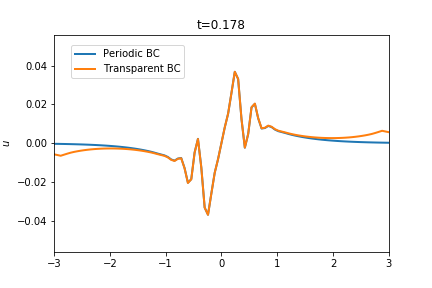
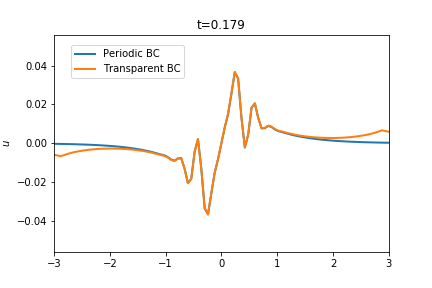
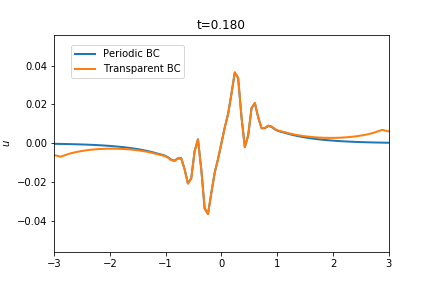
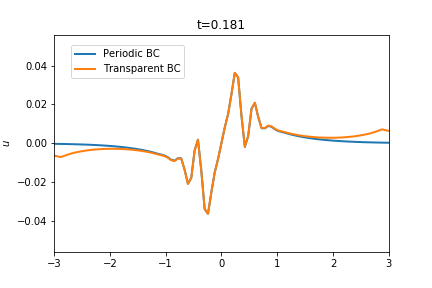
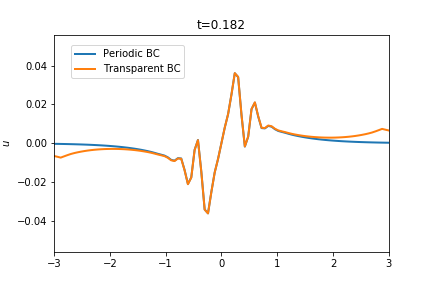
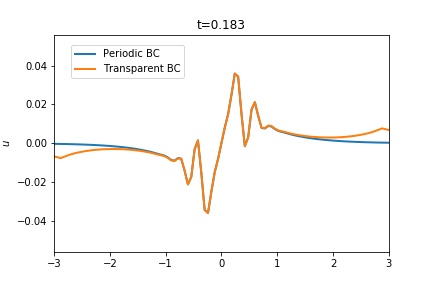
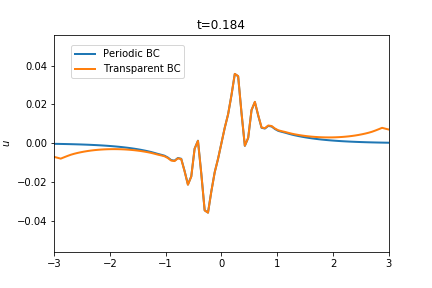
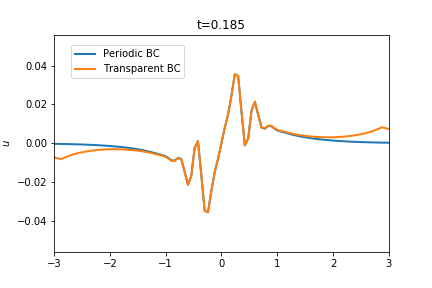
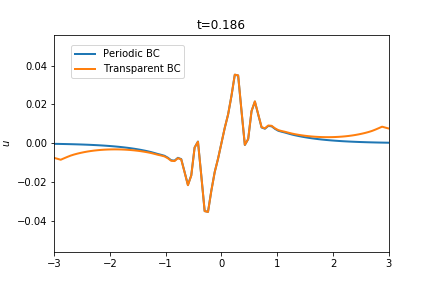
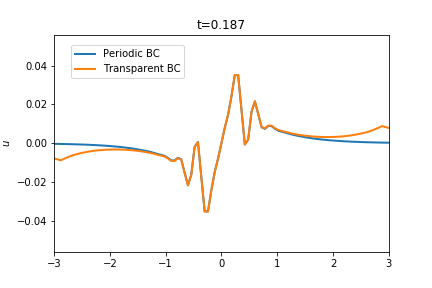
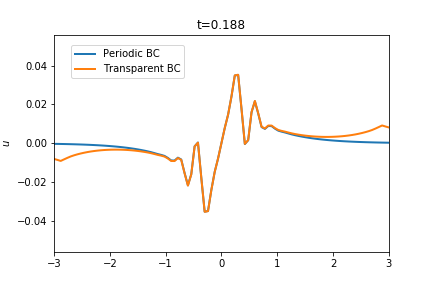
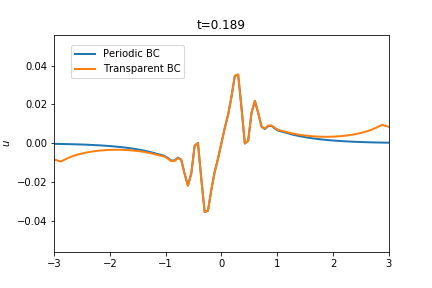
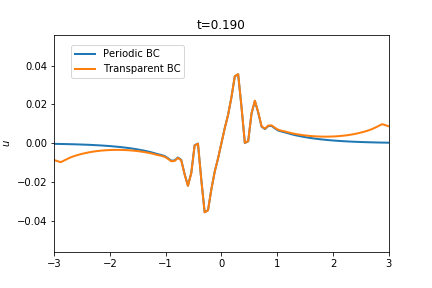
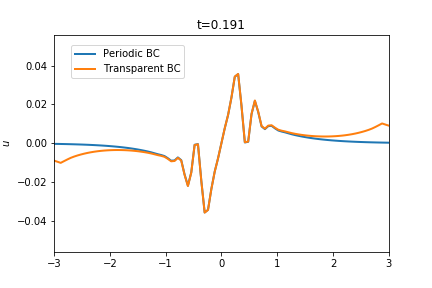
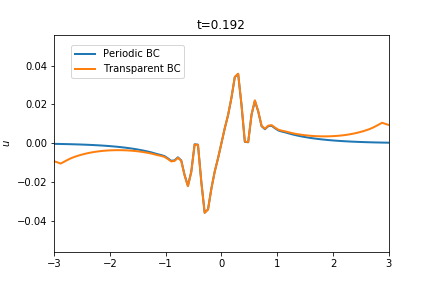
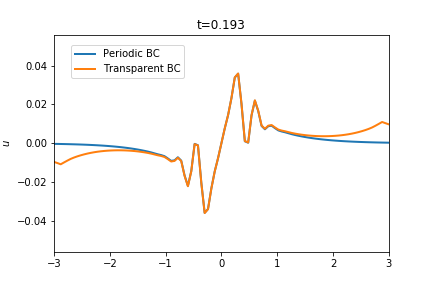
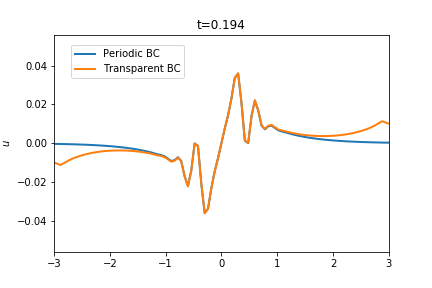
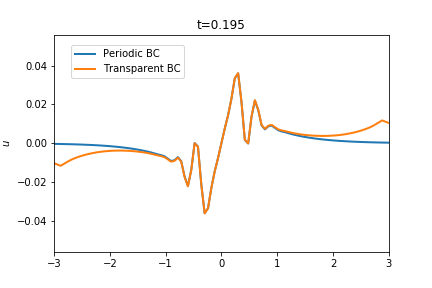
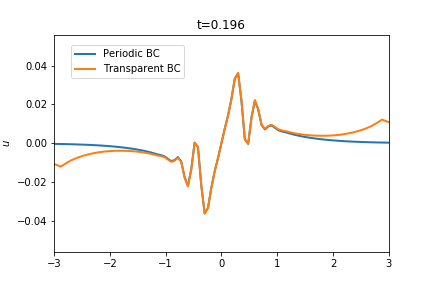
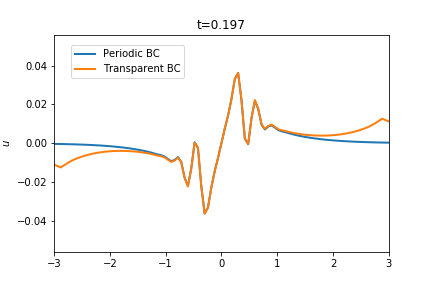
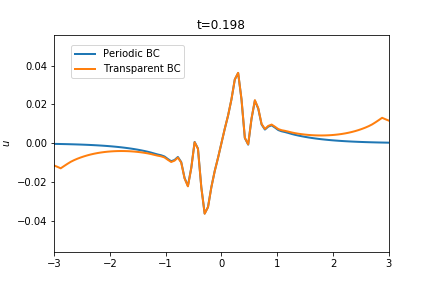
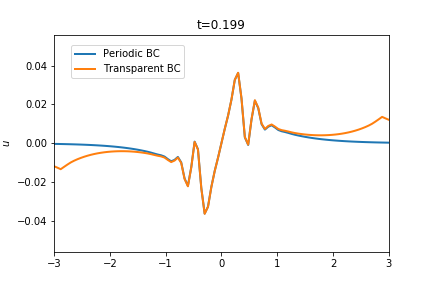
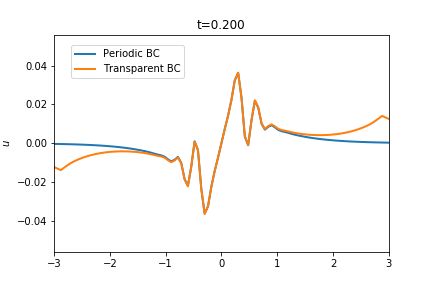

In [22]:
## plotting u
lb = ["Periodic BC", "Transparent BC"]
# save = "./u_TBC_BOSZ_{}.mp4".format(init_cond)
save = None
ng = 2
gF.plotAnimationNSolutions(2,x,np.array([uall1[idx1:idx2],uall2]),tall1,xmin,xmax,umin,umax,lb,ylabel=r'$u$',location=(0.05,0.80),savePath=save)

*** Plotting animation ...



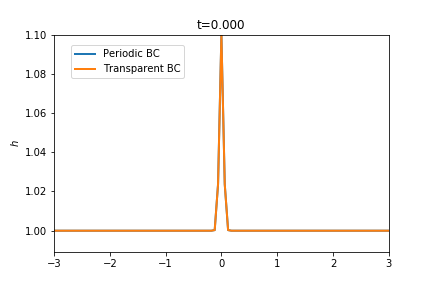
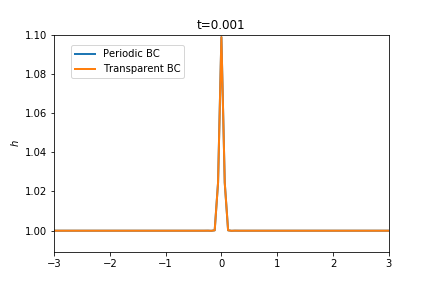
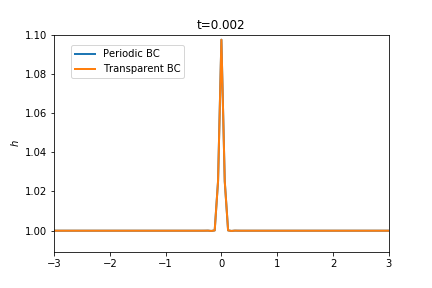
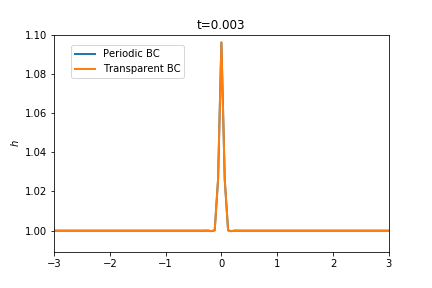
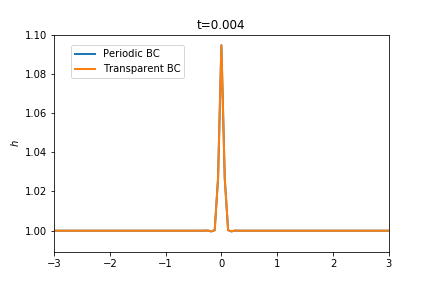
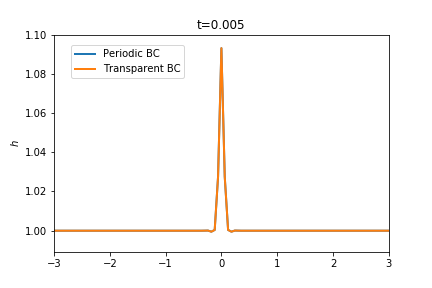
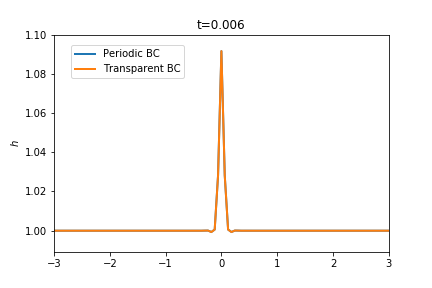
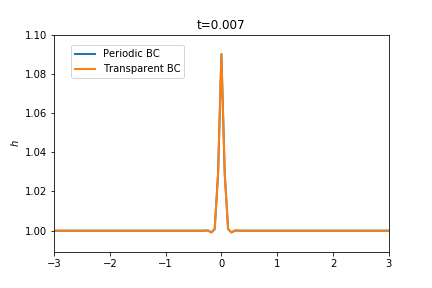
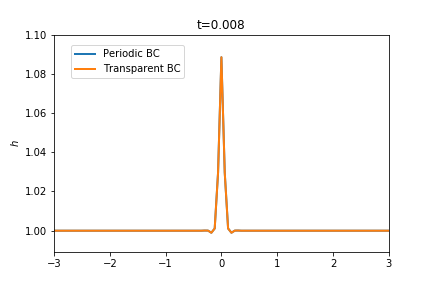
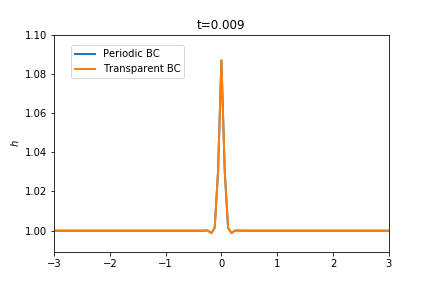
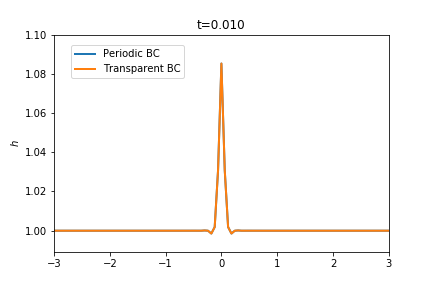
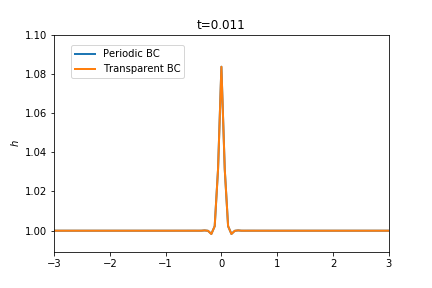
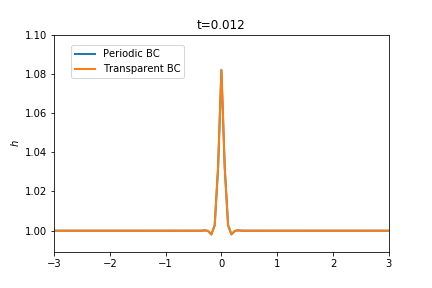
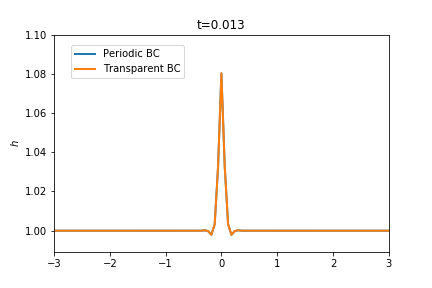
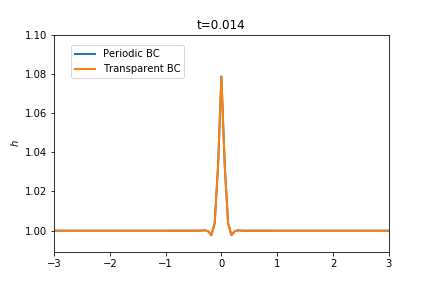
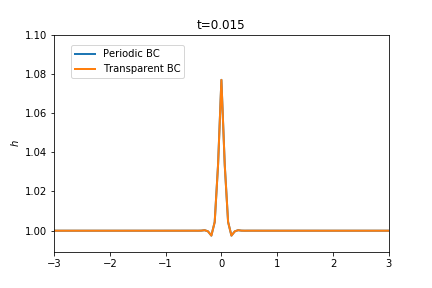
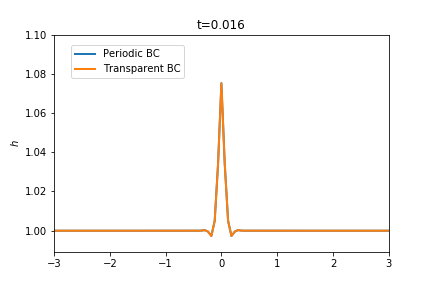
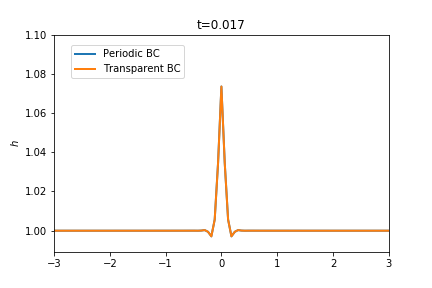
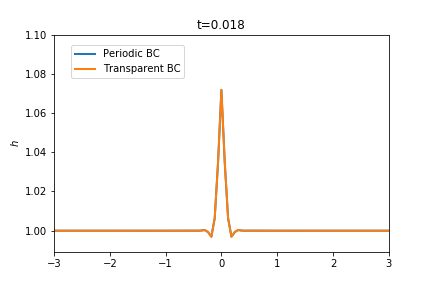
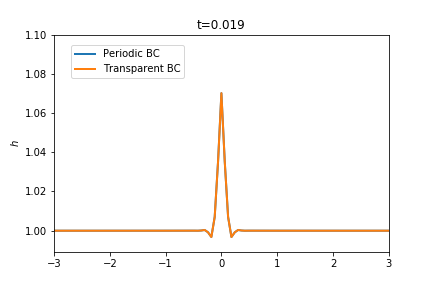
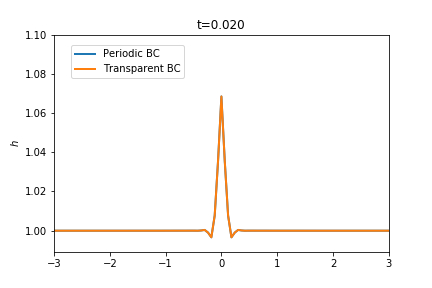
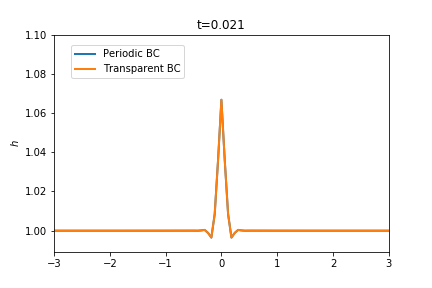
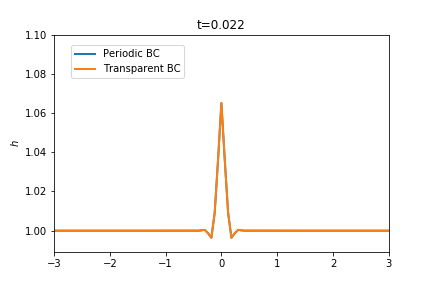
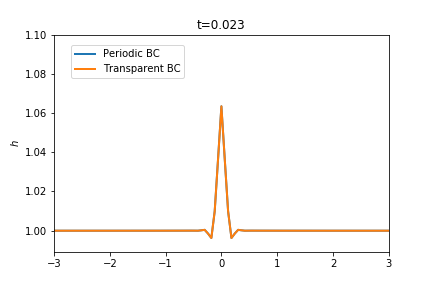
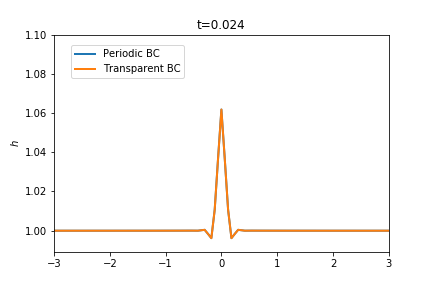
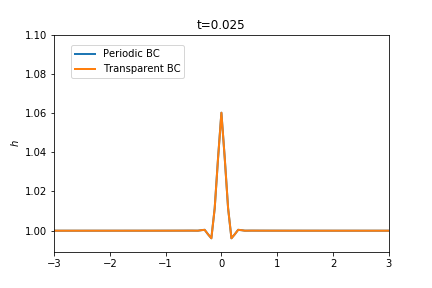
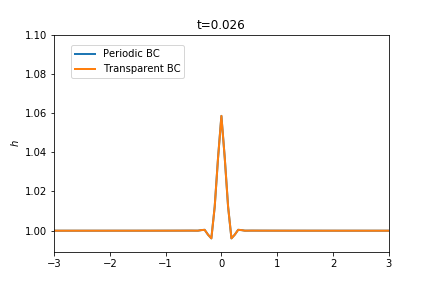
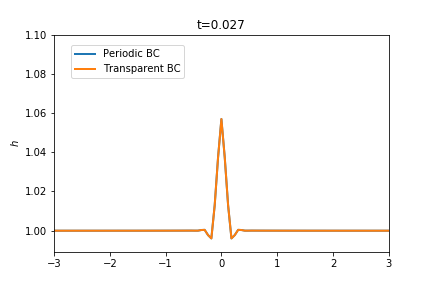
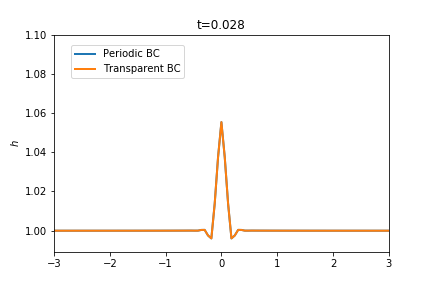
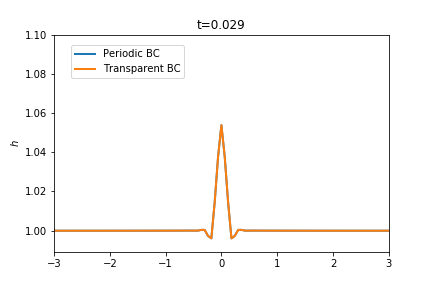
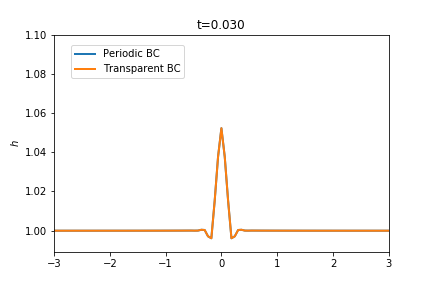
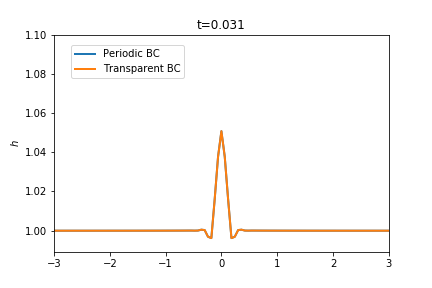
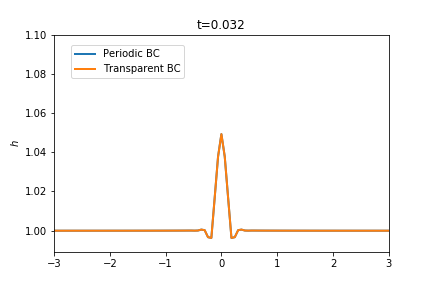
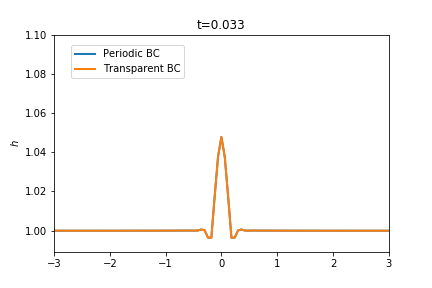
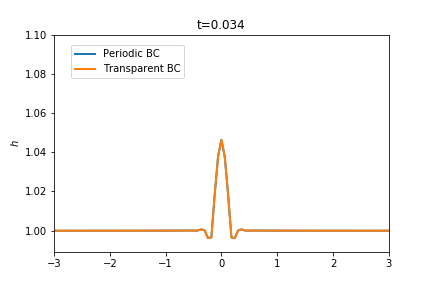
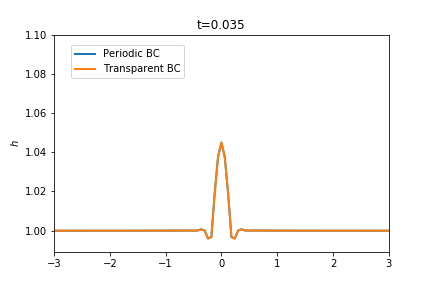
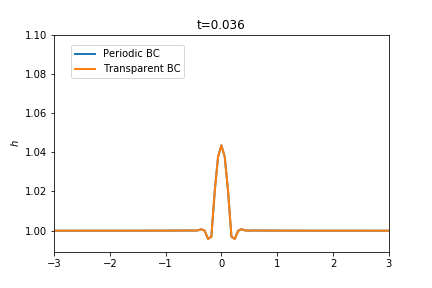
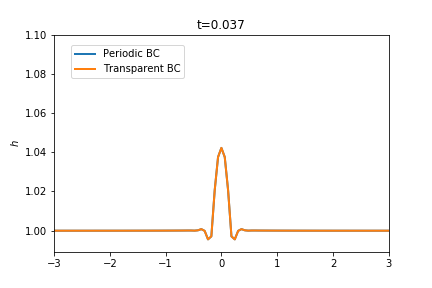
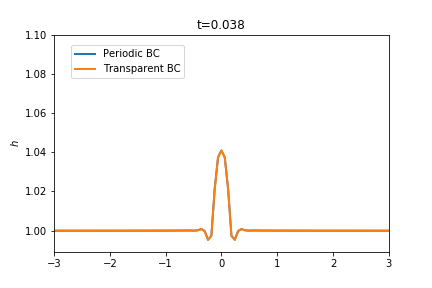
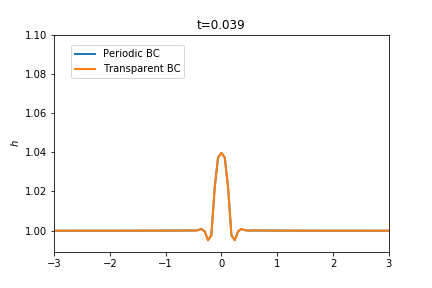
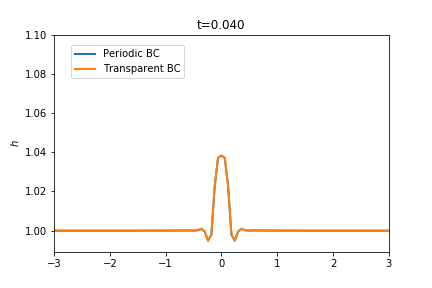
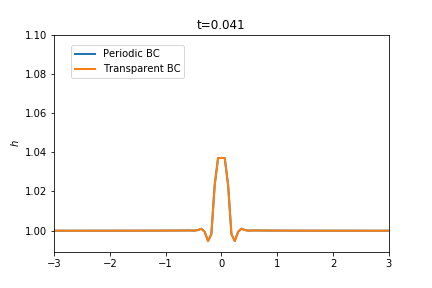
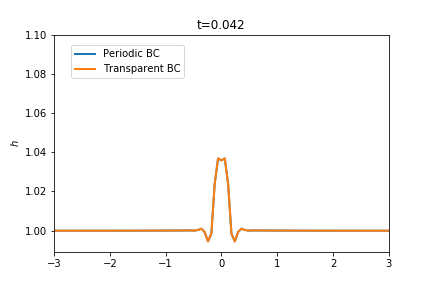
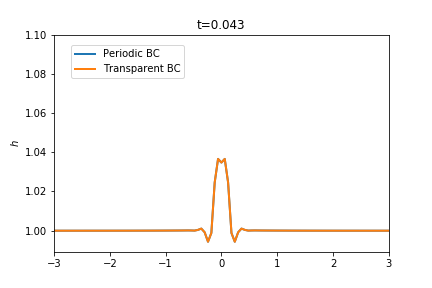
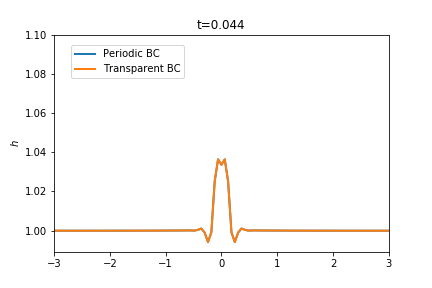
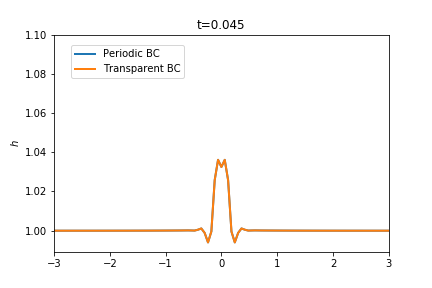
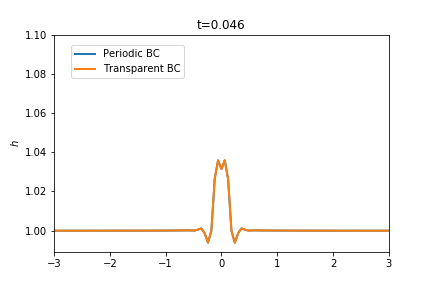
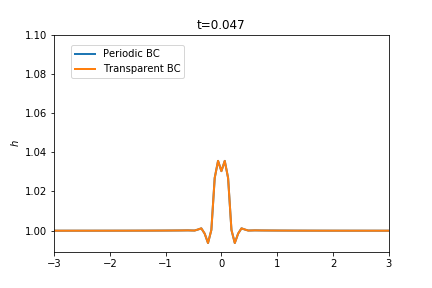
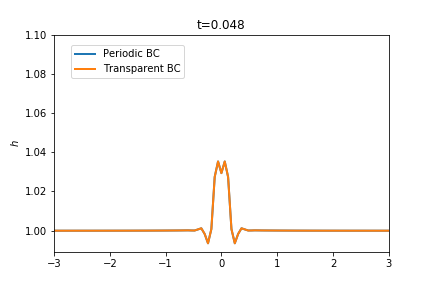
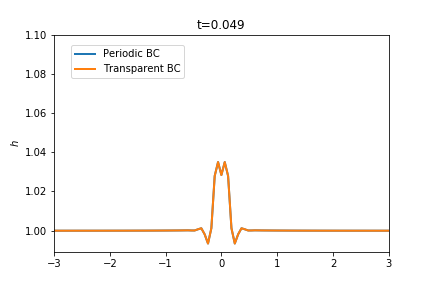
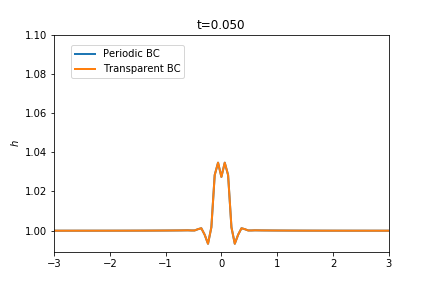
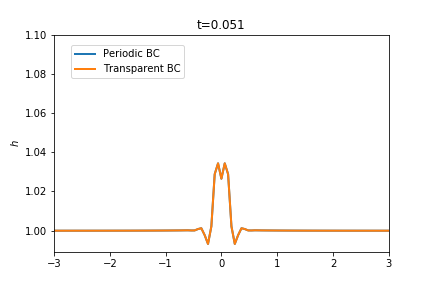
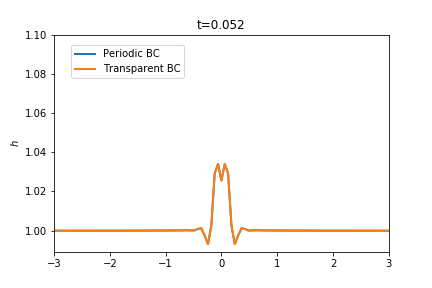
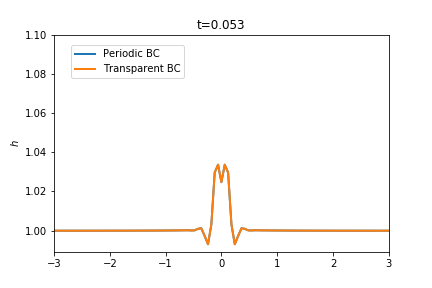
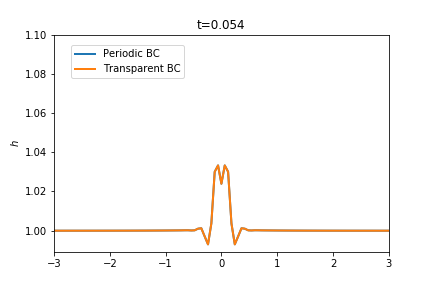
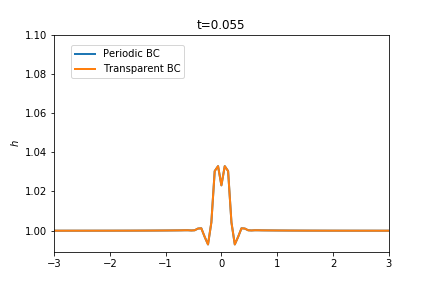
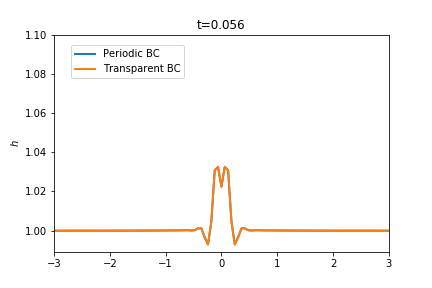
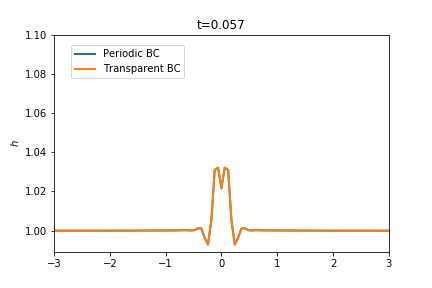
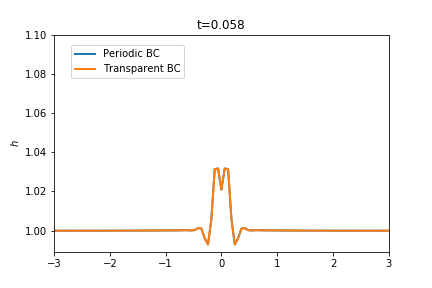
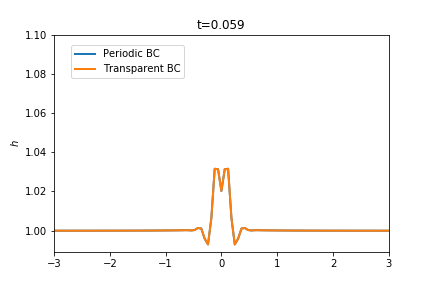
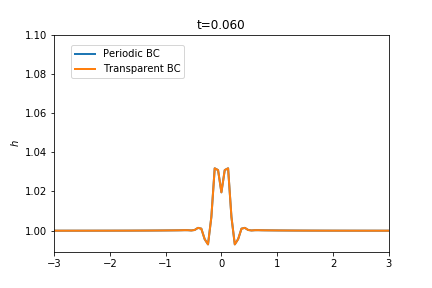
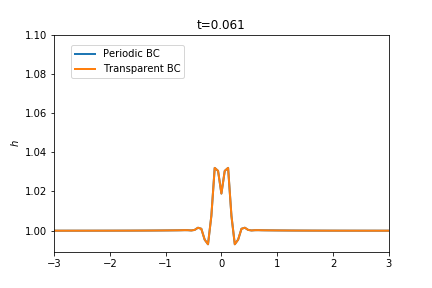
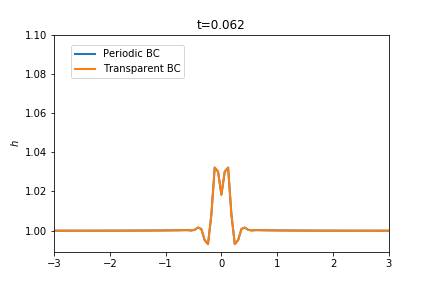
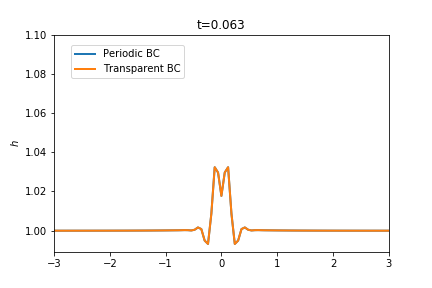
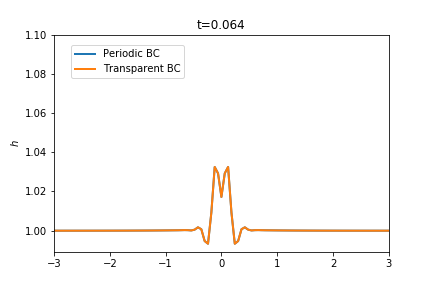
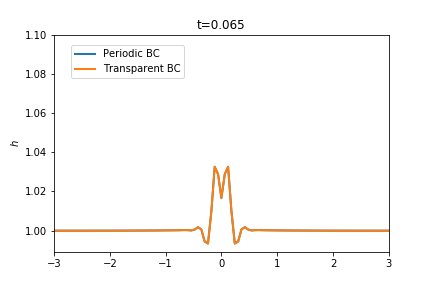
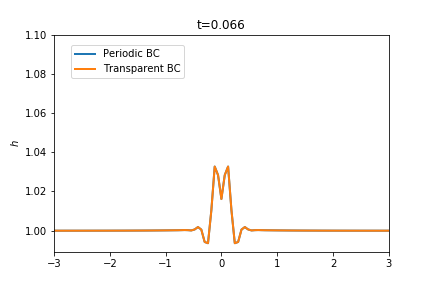
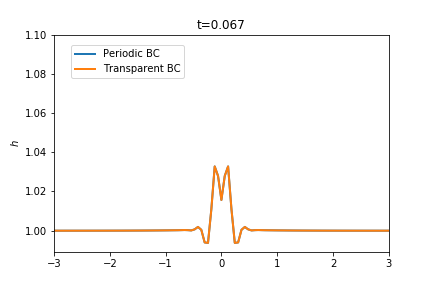
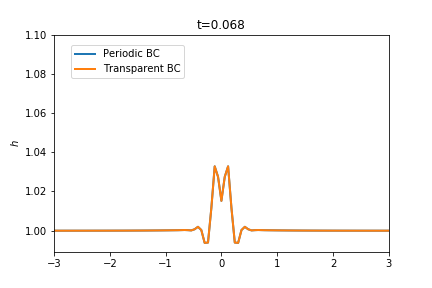
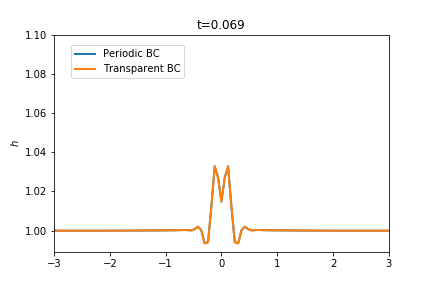
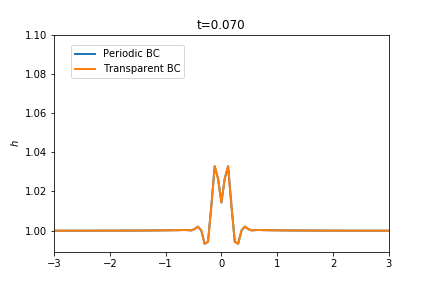
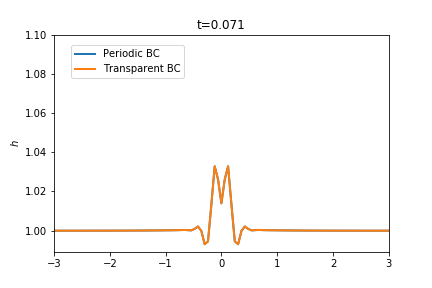
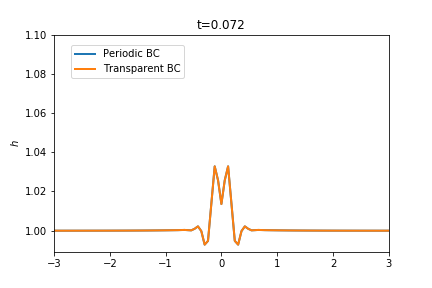
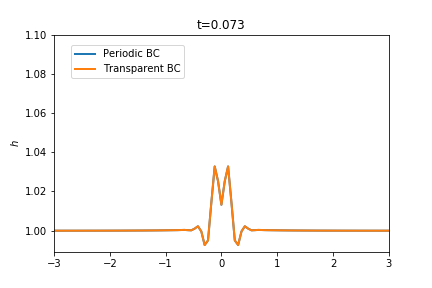
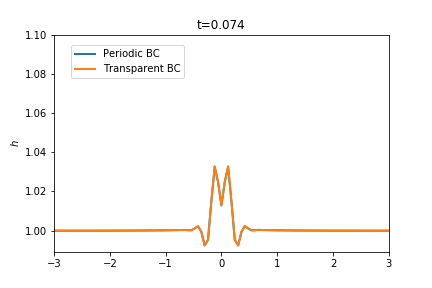
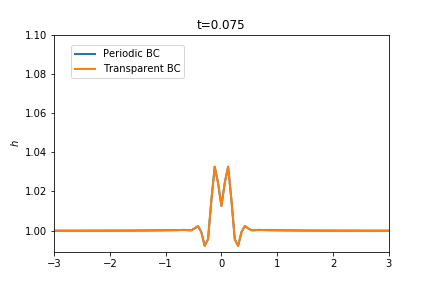
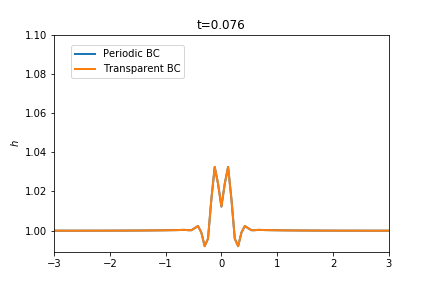
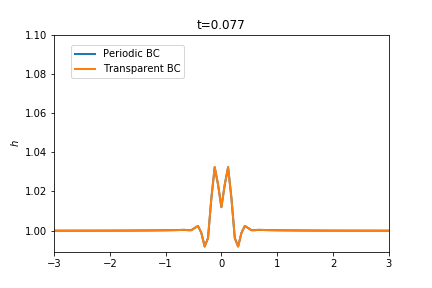
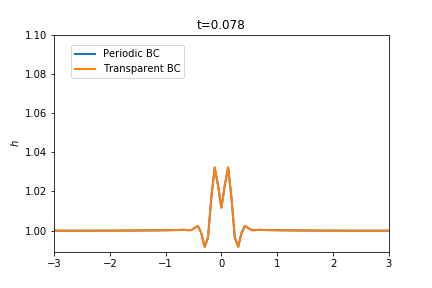
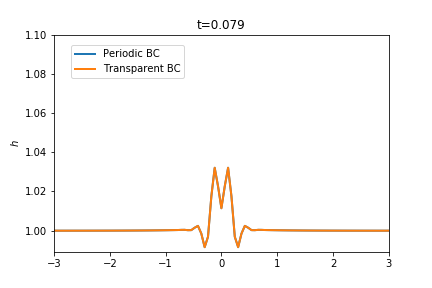
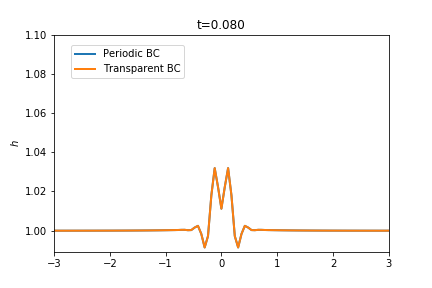
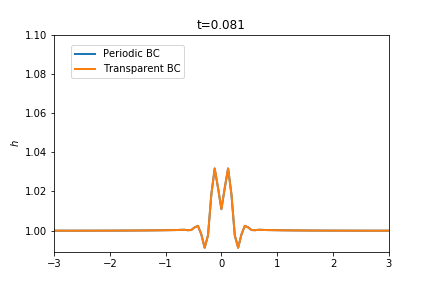
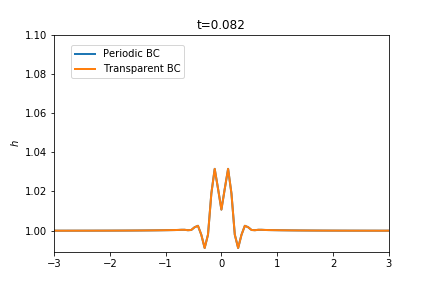
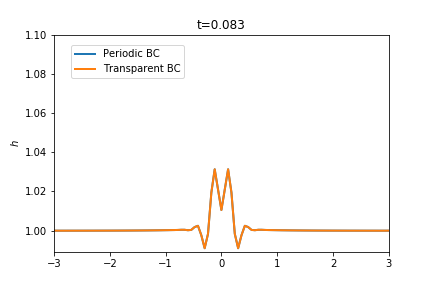
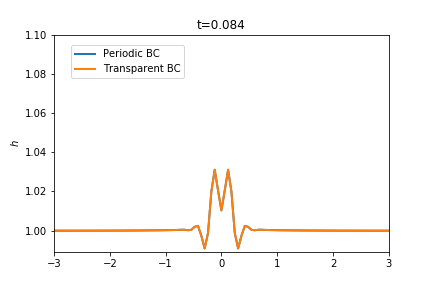
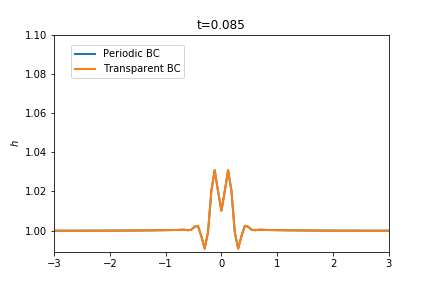
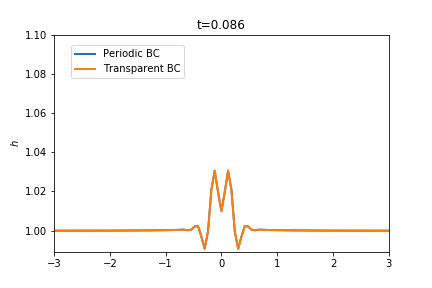
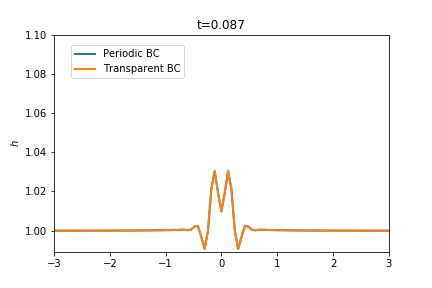
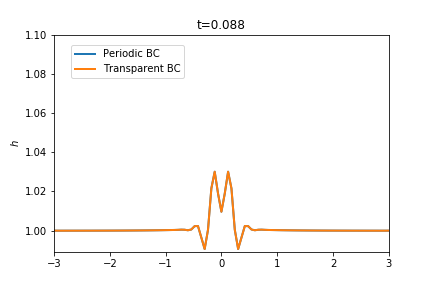
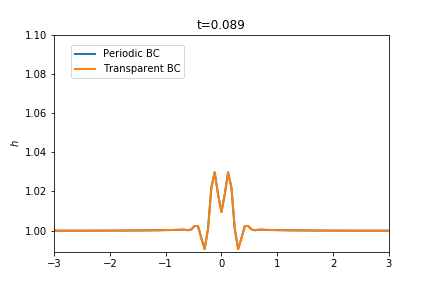
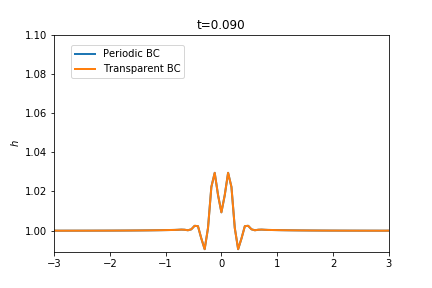
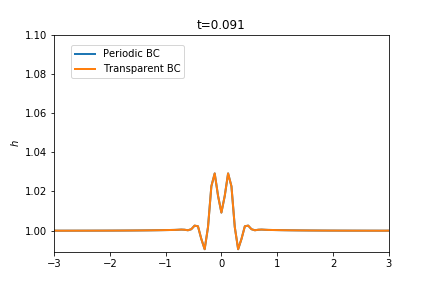
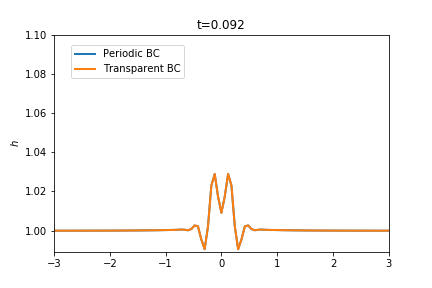
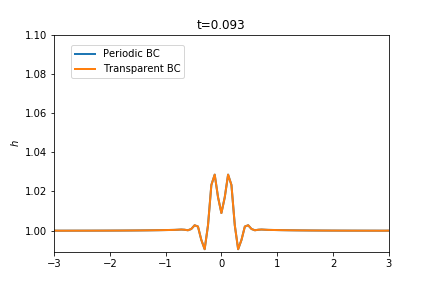
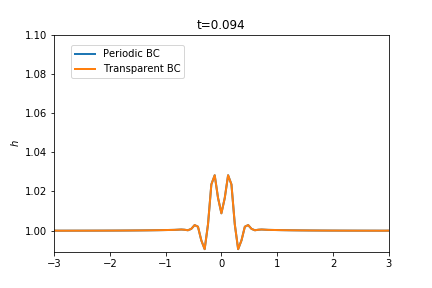
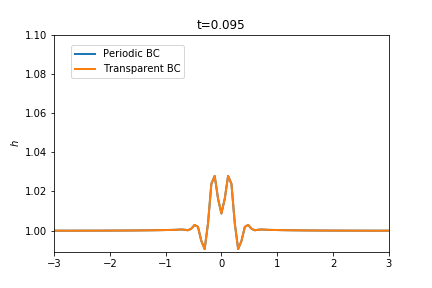
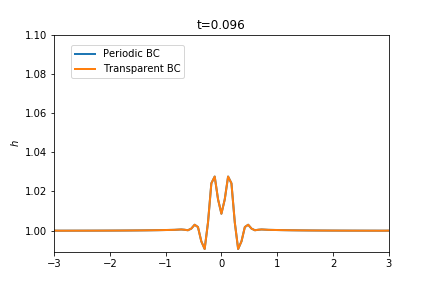
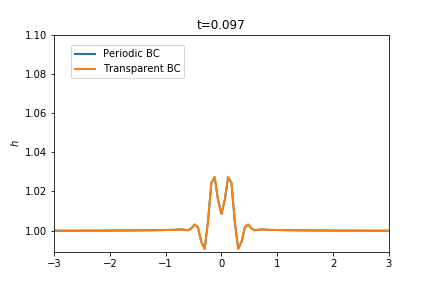
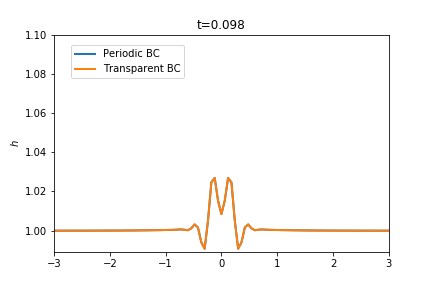
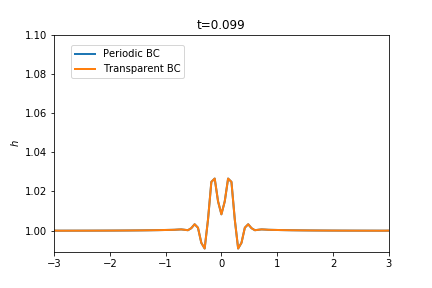
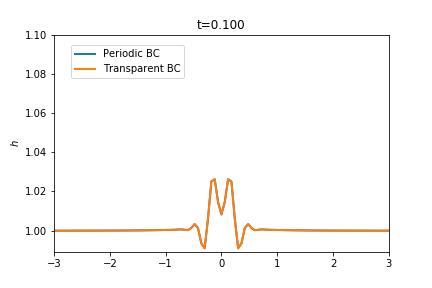
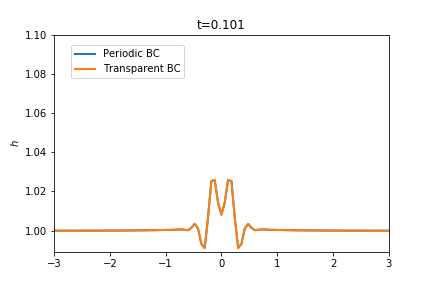
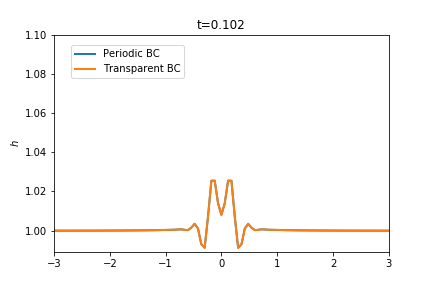
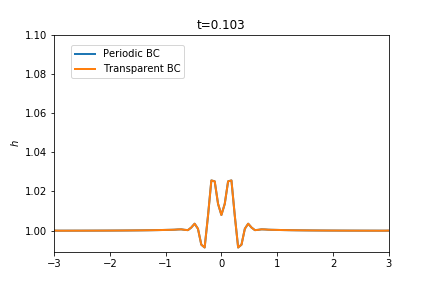
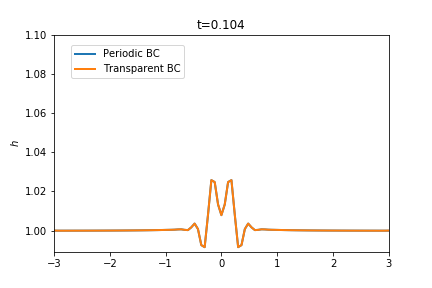
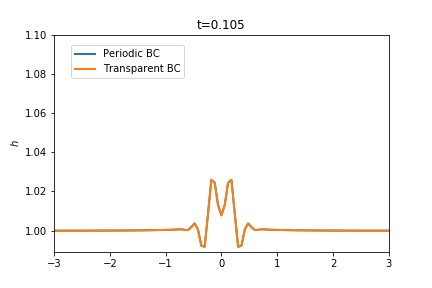
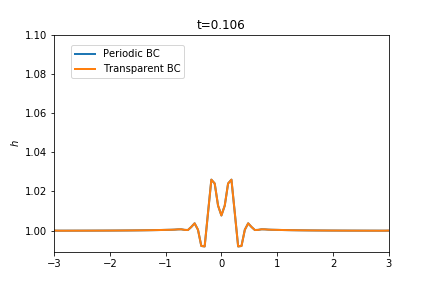
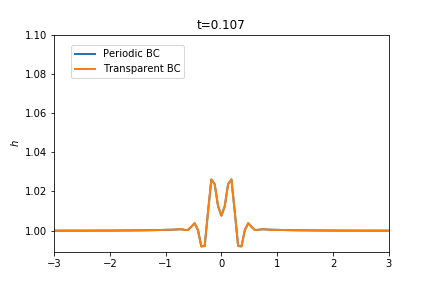
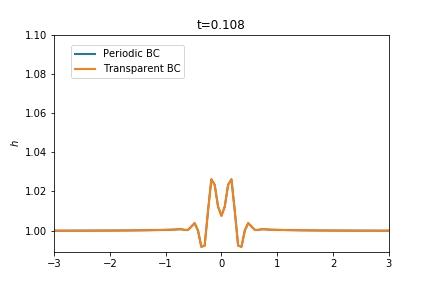
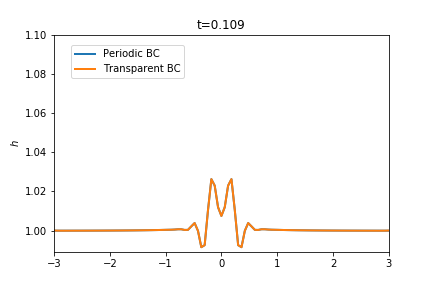
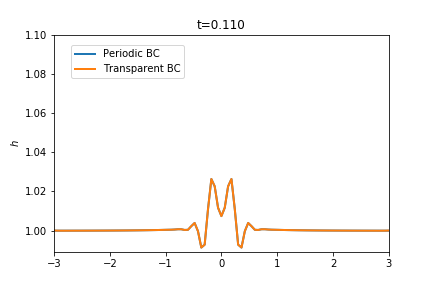
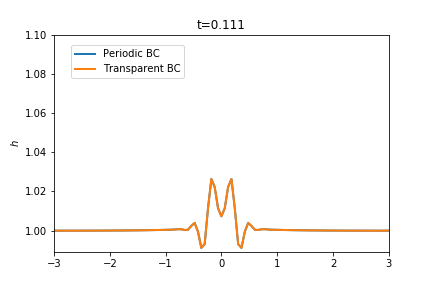
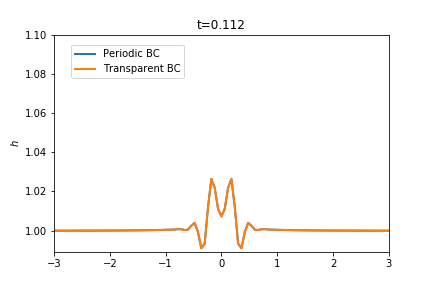
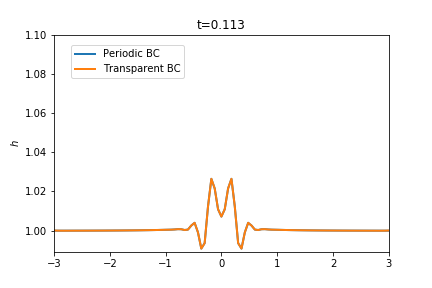
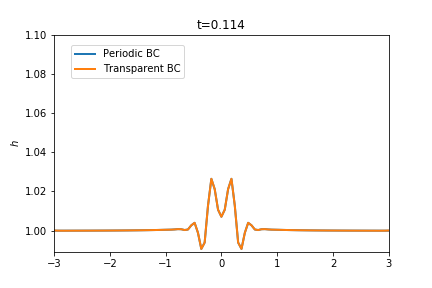
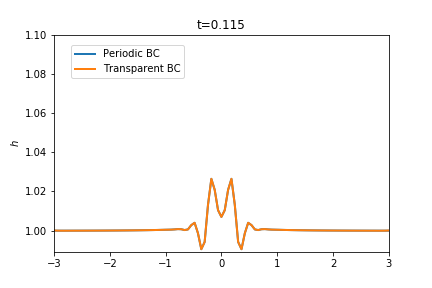
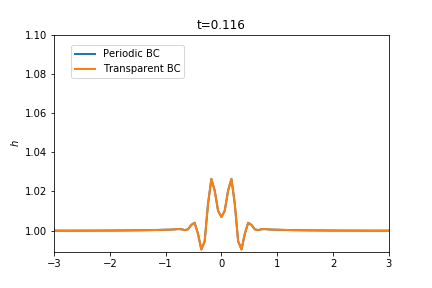
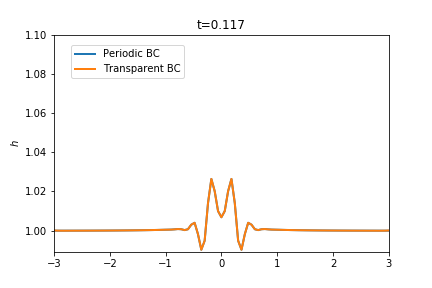
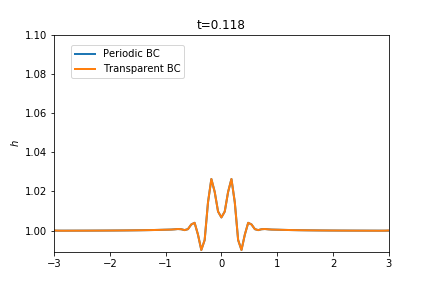
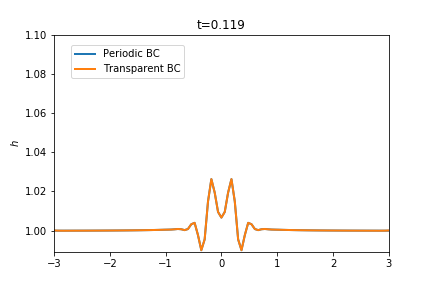
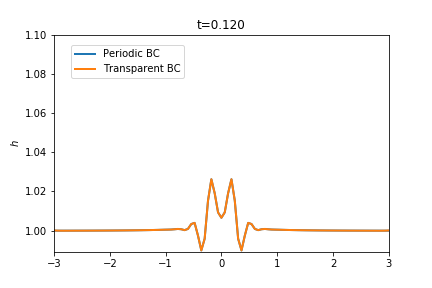
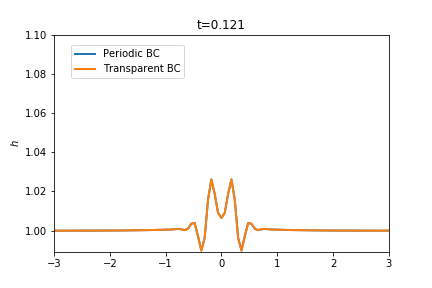
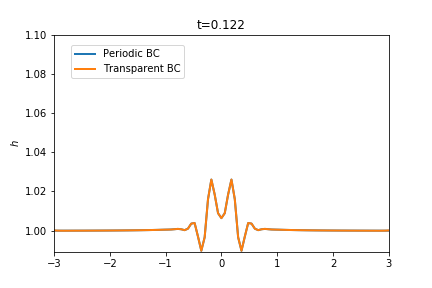
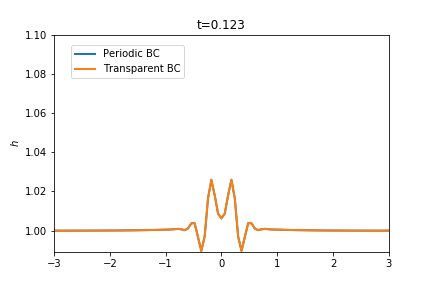
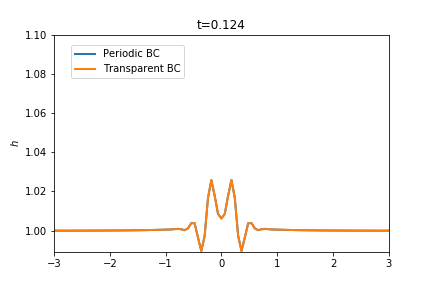
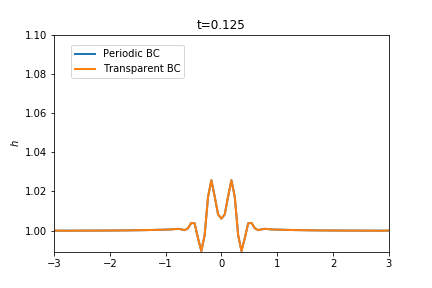
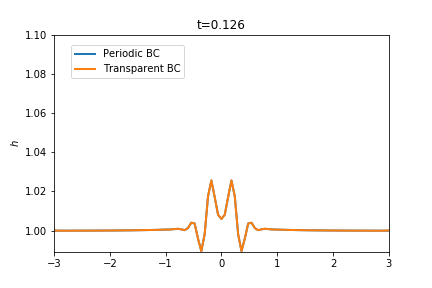
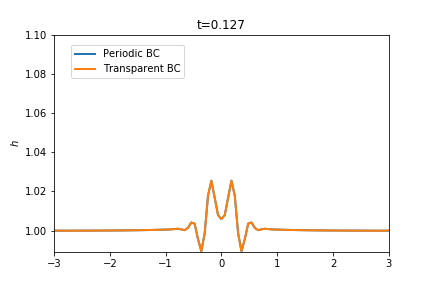
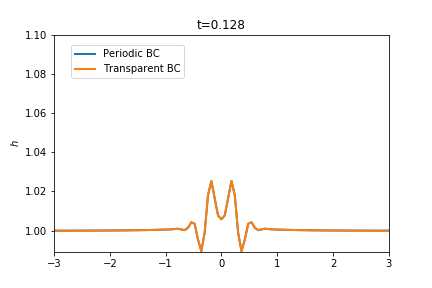
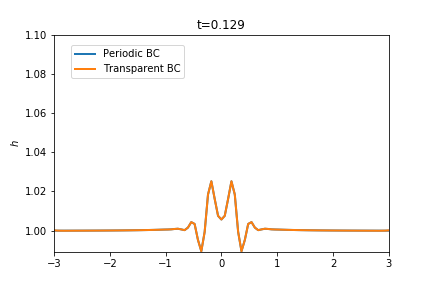
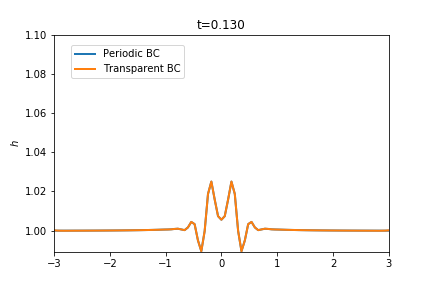
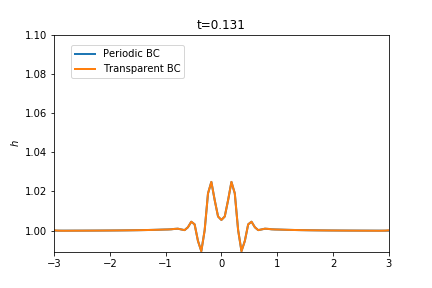
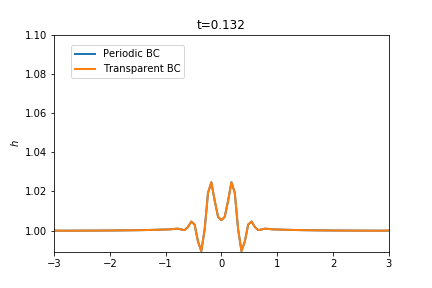
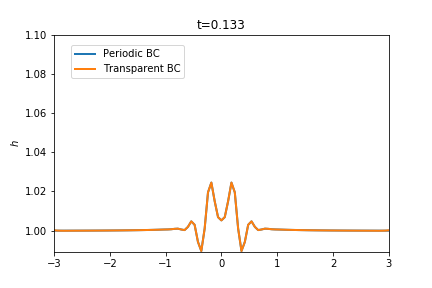
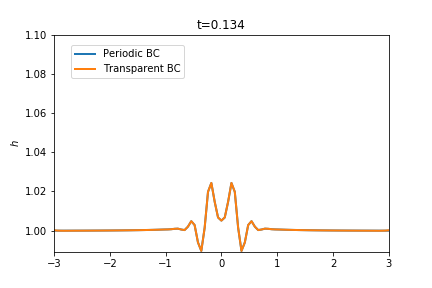
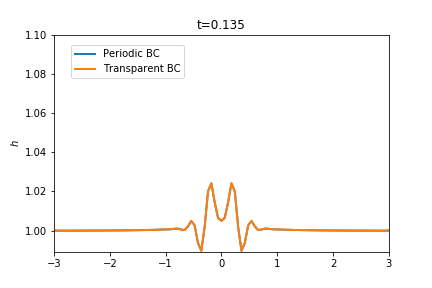
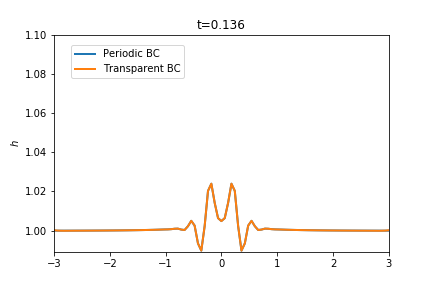
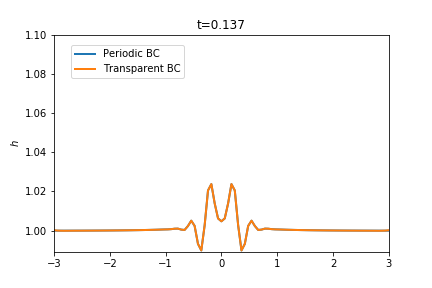
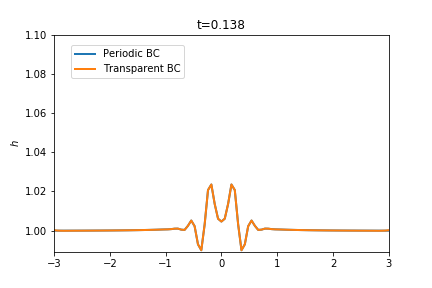
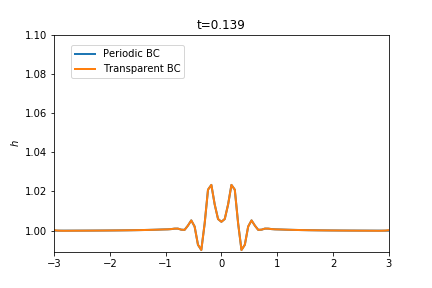
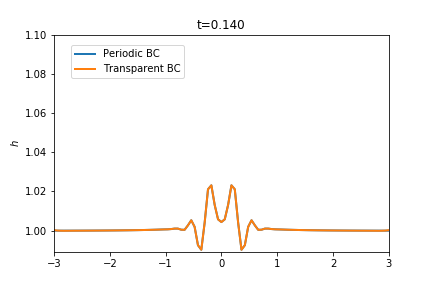
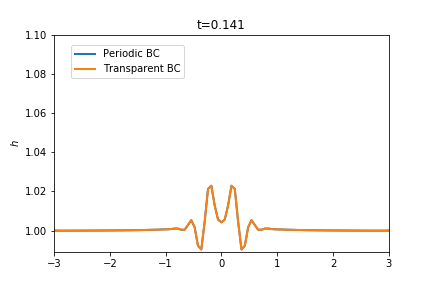
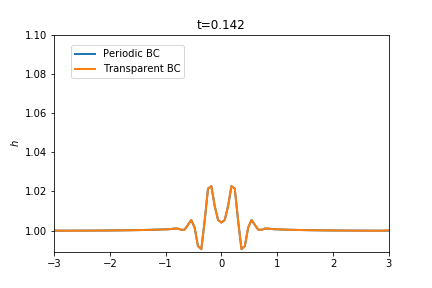
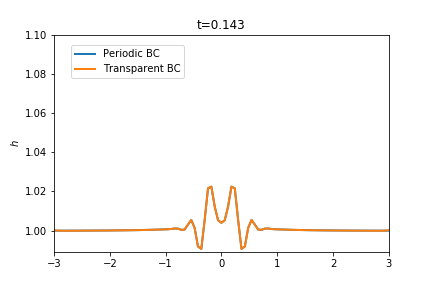
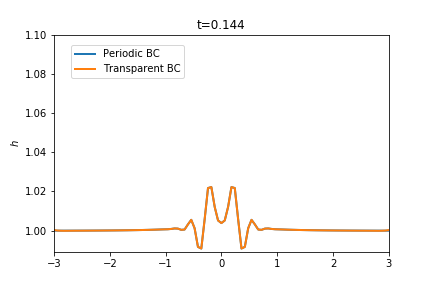
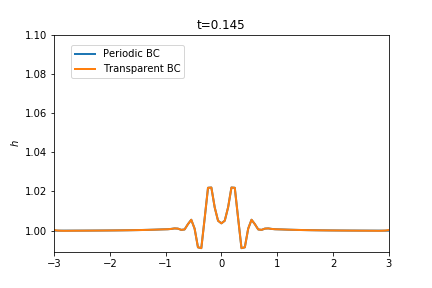
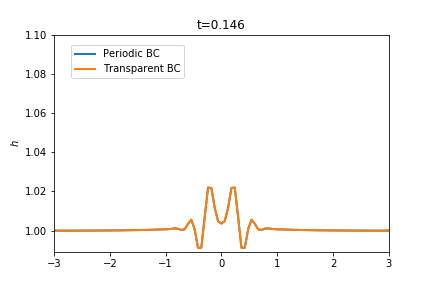
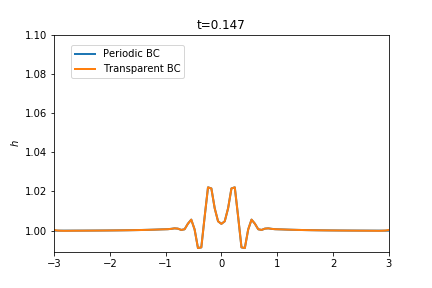
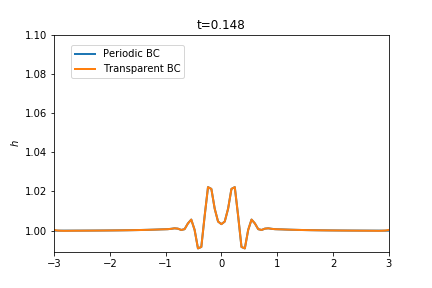
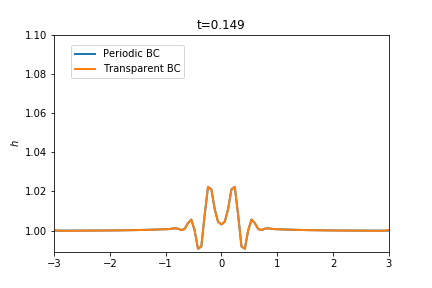
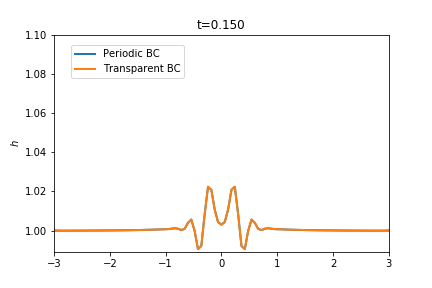
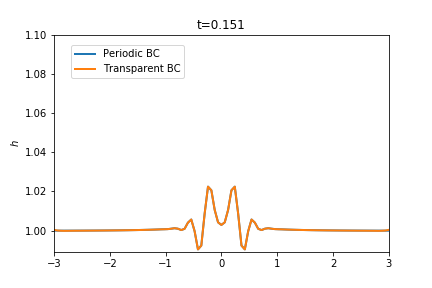
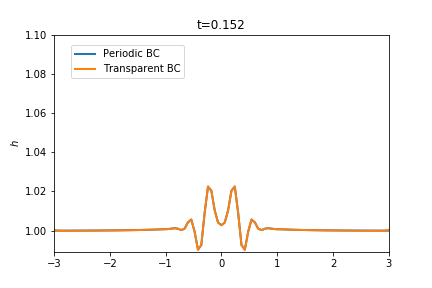
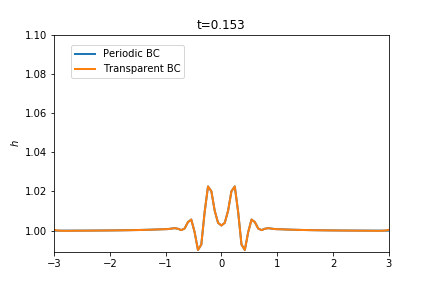
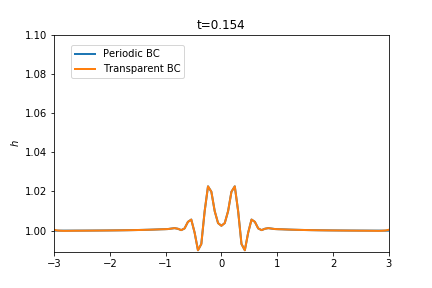
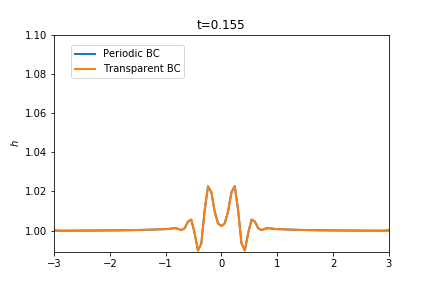
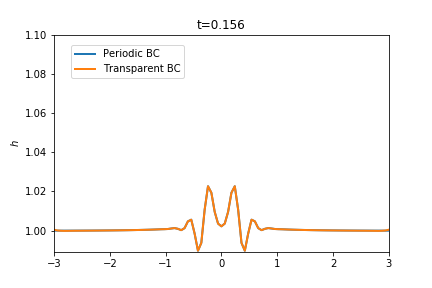
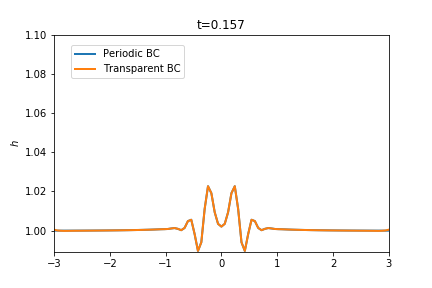
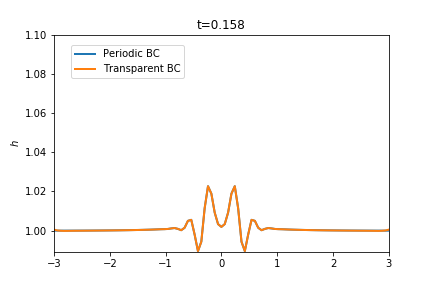
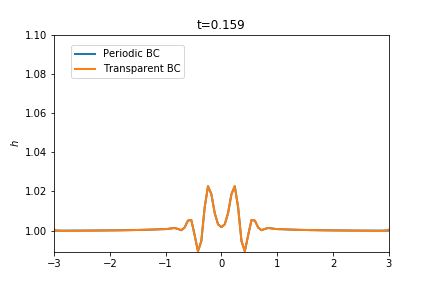
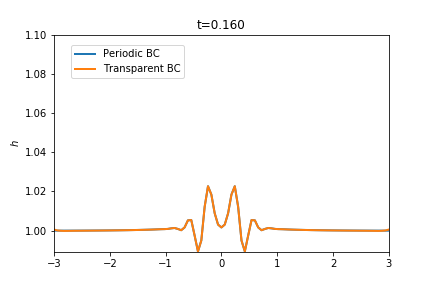
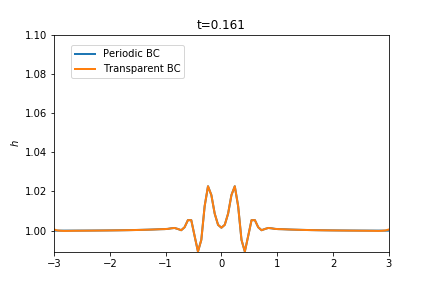
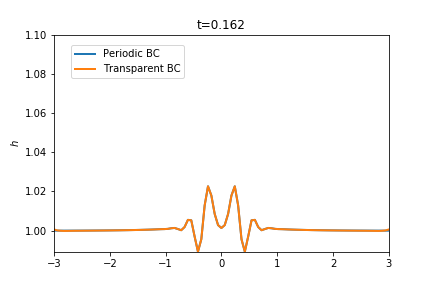
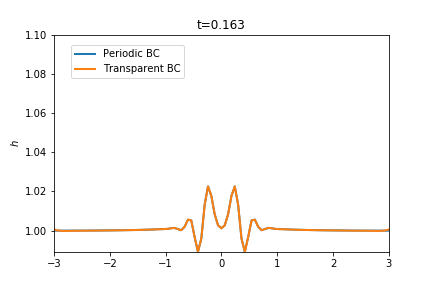
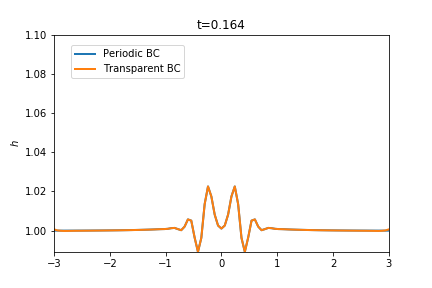
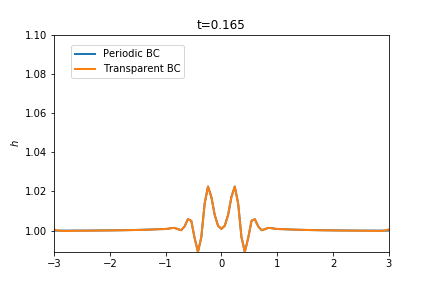
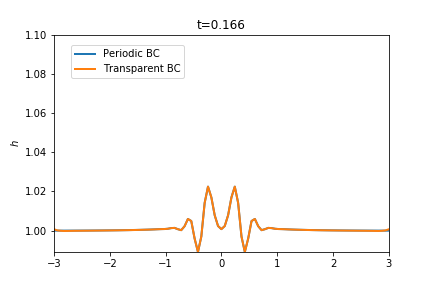
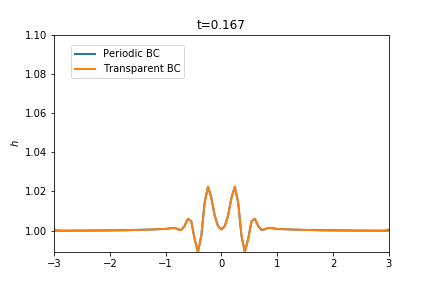
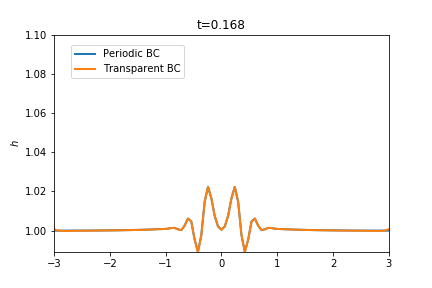
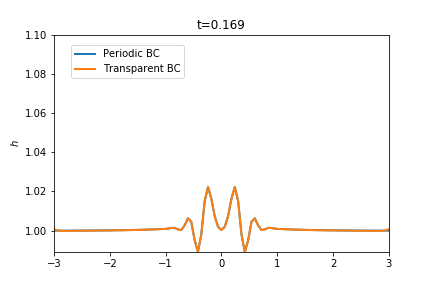
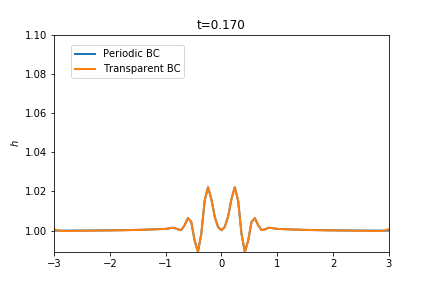
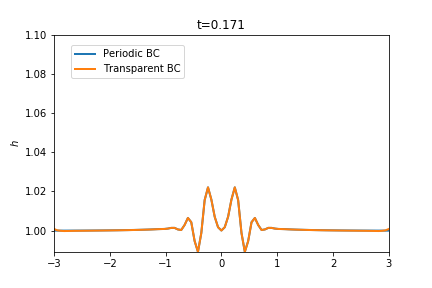
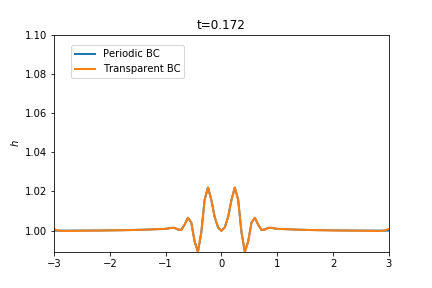
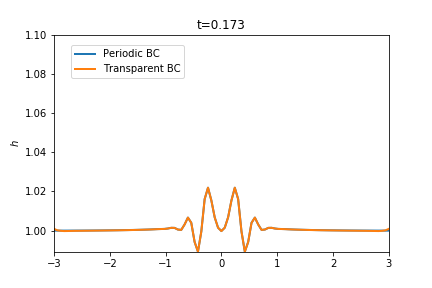
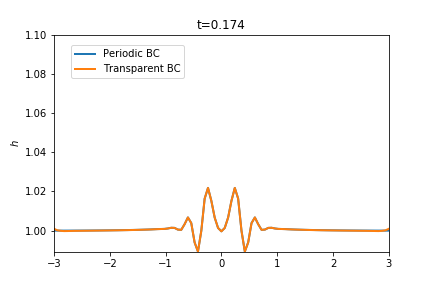
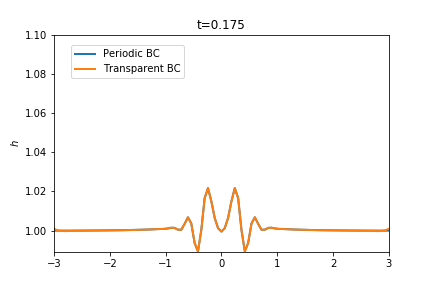
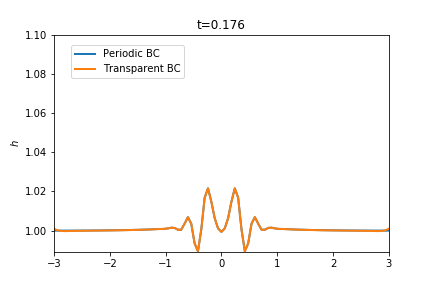
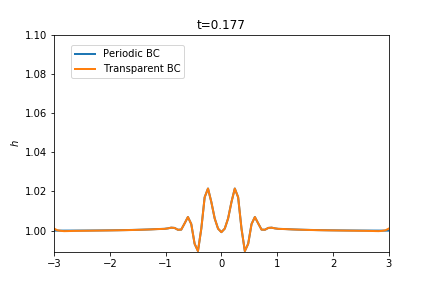
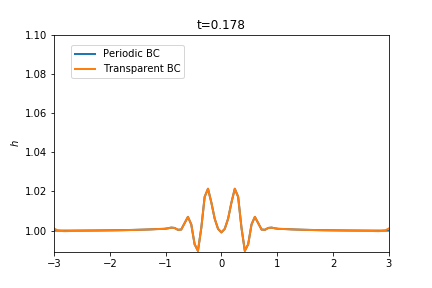
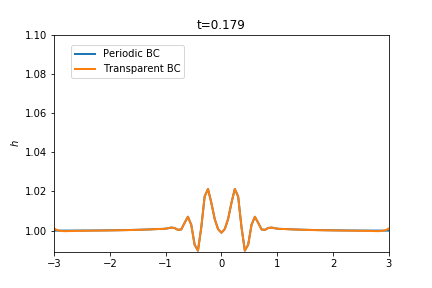
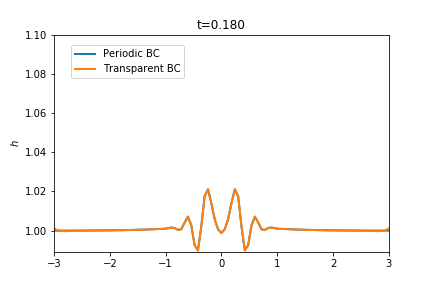
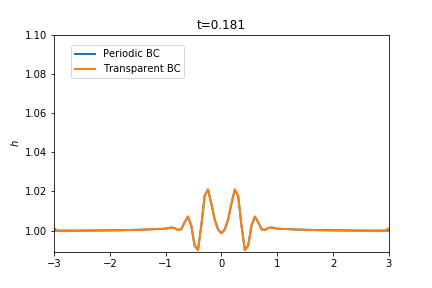
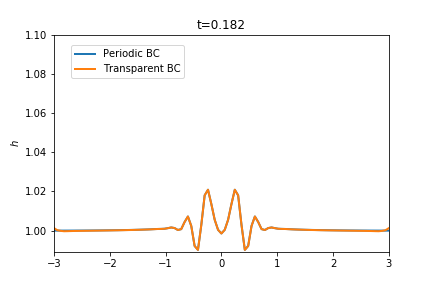
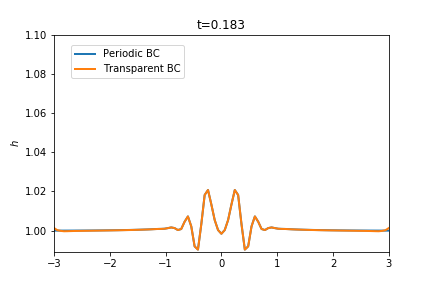
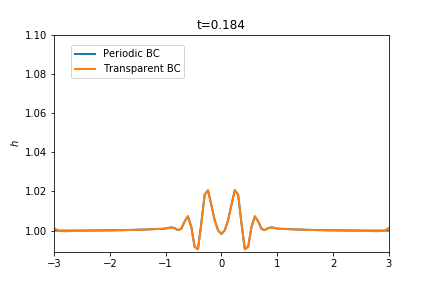
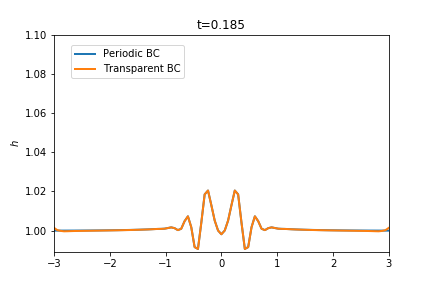
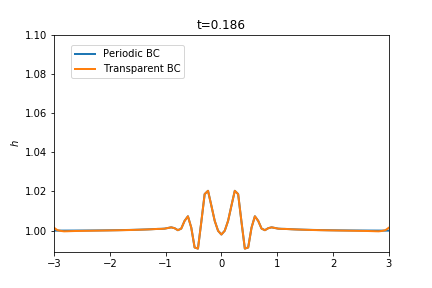
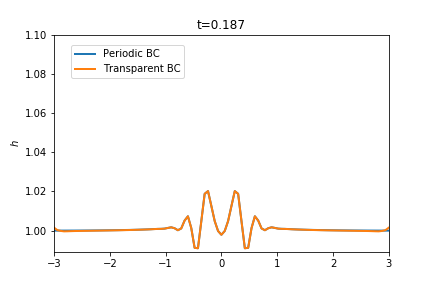
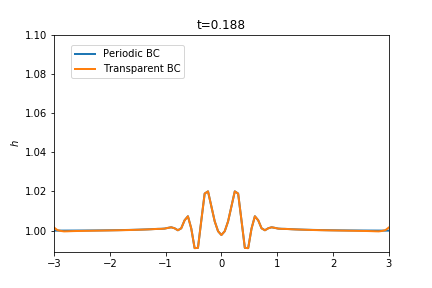
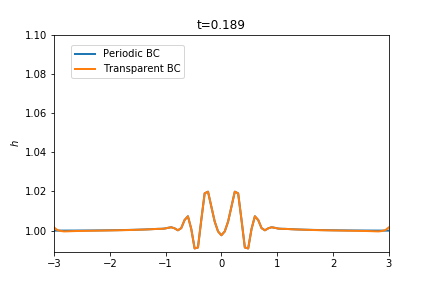
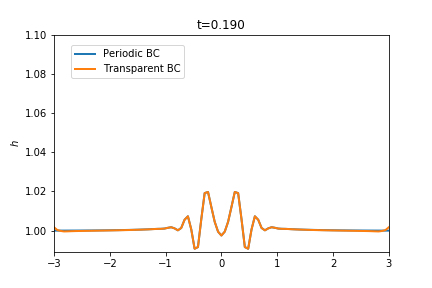
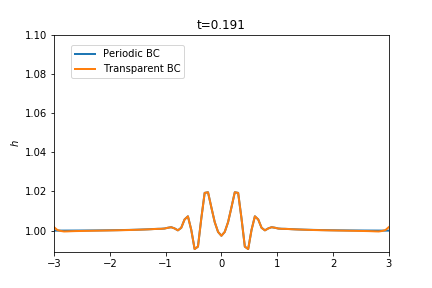
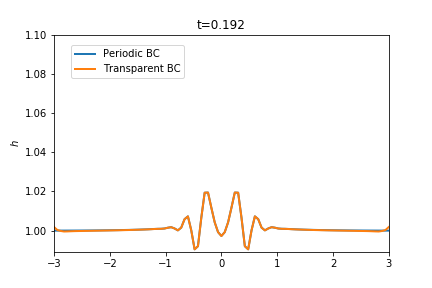
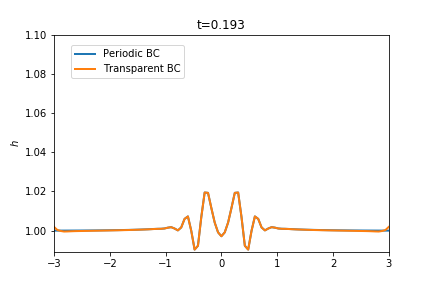
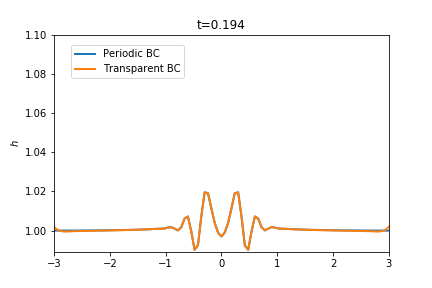
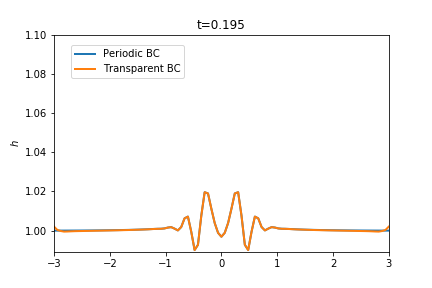
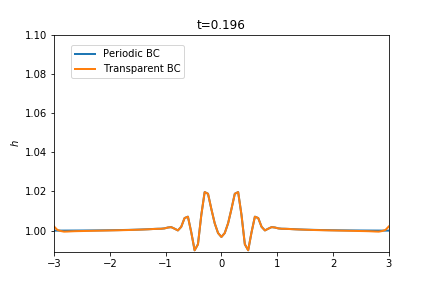
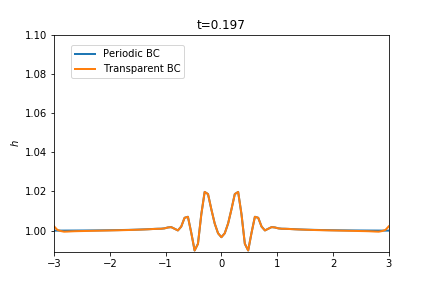
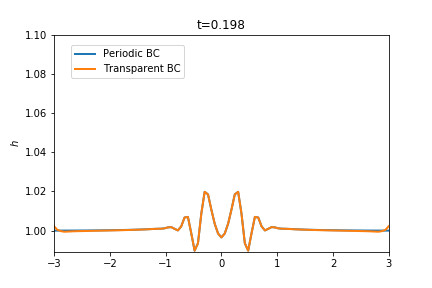
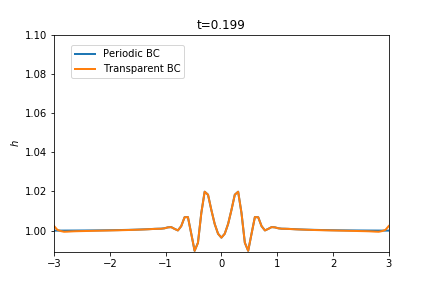
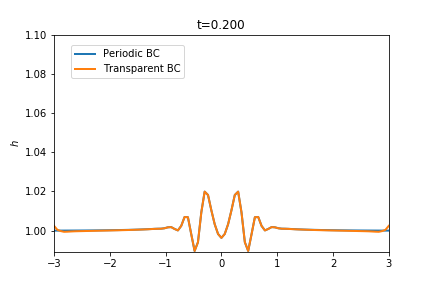

In [23]:
## plotting h
gF.plotAnimationNSolutions(2,x,np.array([hall1[idx1:idx2],hall2]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$',location=(0.05,0.80))